In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import spearmanr

# Path to all model results
CSV_FOLDER = "final_metrics"

all_paths = glob.glob(f"{CSV_FOLDER}/task_metrics_*.csv")

dfs = []
for path in all_paths:
    df = pd.read_csv(path)
    # Make model name consistent / extract from filename
    model_name = path.split("/")[-1].replace("task_metrics_", "").replace(".csv", "")
    df["model_name"] = model_name
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True).dropna(subset=["avg_acc", "avg_latency"])

print("Loaded rows:", len(all_df))
print("Unique models:", all_df.model_name.nunique())
print("Unique tasks:", all_df.task_name.nunique())


Loaded rows: 10598
Unique models: 14
Unique tasks: 757


In [2]:
global_corr, global_p = spearmanr(all_df["avg_acc"], all_df["avg_latency"])
print("GLOBAL acc–latency Spearman:", global_corr, "p:", global_p)


GLOBAL acc–latency Spearman: -0.3137533574962913 p: 8.932793556043298e-241


In [3]:
task_corrs = []
for task, g in all_df.groupby("task_name"):
    if g.model_name.nunique() < 3:
        continue
    rho, p = spearmanr(g.avg_acc, g.avg_latency)
    task_corrs.append({
        "task_name": task,
        "rho": rho,
        "p": p,
        "category": g.category.iloc[0],
        "domain": g.domain.iloc[0]
    })

task_corrs_df = pd.DataFrame(task_corrs)
tradeoff_tasks = task_corrs_df[(task_corrs_df.rho > 0.5) & (task_corrs_df.p < 0.1)]
tradeoff_tasks = tradeoff_tasks.sort_values("rho", ascending=False)

tradeoff_tasks.head(12)

/tmp/ipykernel_6587/2059325229.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(g.avg_acc, g.avg_latency)


task_name       rho         p  \
355               task192_hotpotqa_sentence_generation  0.635165  0.014658   
393  task287_casehold_legal_incorrect_answer_genera...  0.635165  0.014658   
323          task168_strategyqa_question_decomposition  0.600000  0.023308   
692                 task849_pubmedqa_answer_generation  0.560440  0.037104   
352                           task183_rhyme_generation  0.537086  0.047652   
330                      task1711_poki_text_generation  0.512088  0.061198   

                       category         domain  
355                 Explanation      Wikipedia  
393  Wrong Candidate Generation            Law  
323      Question Decomposition      Wikipedia  
692          Question Answering       Medicine  
352                       Misc.  Miscellaneous  
330             Poem Generation          Books

In [4]:
def strictly_monotone_tradeoff(group):
    g = group.sort_values("avg_acc")
    lat = g.avg_latency.values
    return np.all(lat[1:] >= lat[:-1] - 1e-6)

monotone_list = []
for task, g in all_df.groupby("task_name"):
    if g.model_name.nunique() < 4:  
        continue
    if strictly_monotone_tradeoff(g):
        monotone_list.append(task)

print("Tasks with strict monotone latency increasing when accuracy increasing:")
monotone_list[:10]

Tasks with strict monotone latency increasing when accuracy increasing:


[]

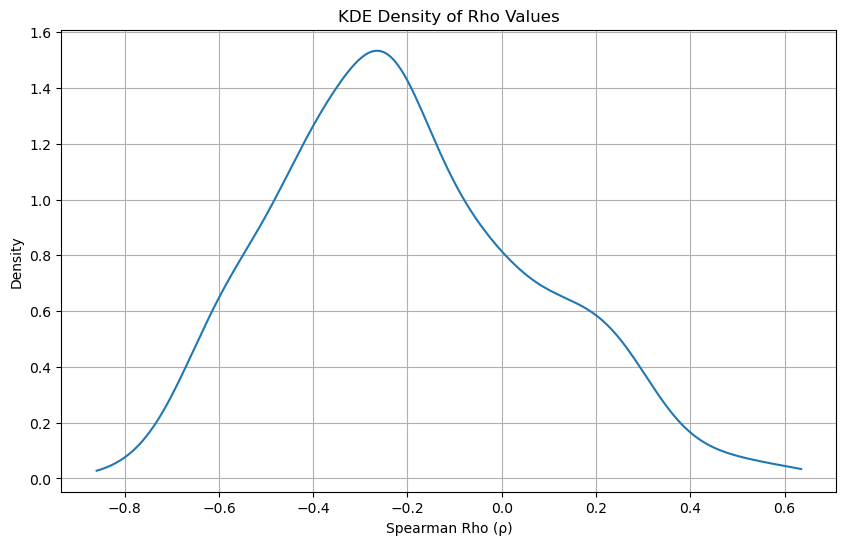

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

rho_values = task_corrs_df['rho'].dropna().values
density = gaussian_kde(rho_values)
xs = np.linspace(min(rho_values), max(rho_values), 200)

plt.figure(figsize=(10, 6))
plt.plot(xs, density(xs))
plt.title("KDE Density of Rho Values")
plt.xlabel("Spearman Rho (ρ)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Loaded 10598 rows from 14 CSV files.
Models found: ['google_flan-t5-large' 'google_flan-t5-xxl (q)'
 'Qwen_Qwen2-1.5B-Instruct' 'google_flan-t5-xl' 'bigscience_T0_3B'
 'allenai_tk-instruct-3b-def' 'google_flan-t5-xxl'
 'Qwen_Qwen2.5-1.5B-Instruct' 'Qwen_Qwen2.5-7B-Instruct'
 'Qwen_Qwen3-4B-Instruct-2507' 'microsoft_Phi-3-mini-4k-instruct'
 'microsoft_Phi-3.5-mini-instruct'
 'zephyr3b_stabilityai_stablelm-zephyr-3b' 'microsoft_Phi-4-mini-instruct']
PASS: All models have a size mapping.

Per-model mean accuracy, latency, and size:
                                 model_name  mean_accuracy  mean_latency  \
0                  Qwen_Qwen2-1.5B-Instruct       0.455511      0.287538   
1                Qwen_Qwen2.5-1.5B-Instruct       0.463807      0.345298   
2                  Qwen_Qwen2.5-7B-Instruct       0.557206      0.366799   
3               Qwen_Qwen3-4B-Instruct-2507       0.520550      0.914844   
4                allenai_tk-instruct-3b-def       0.583999      0.282294   
5        

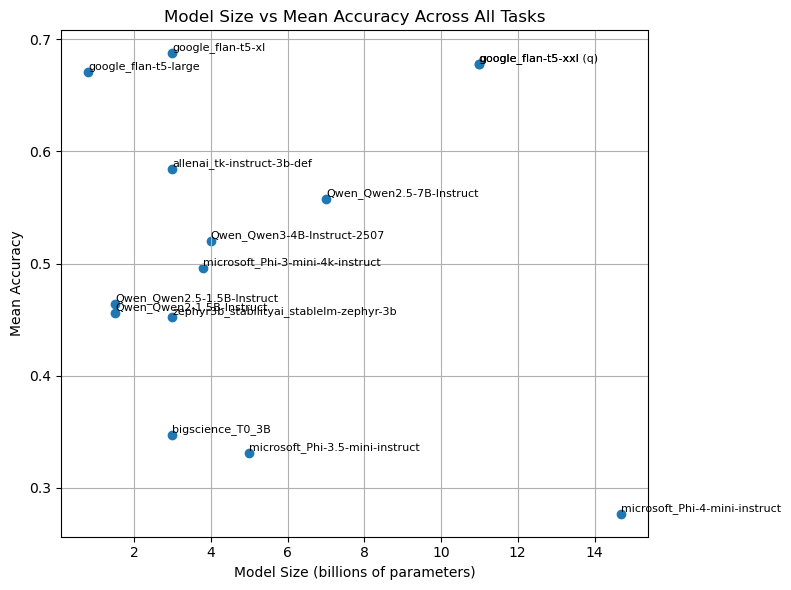

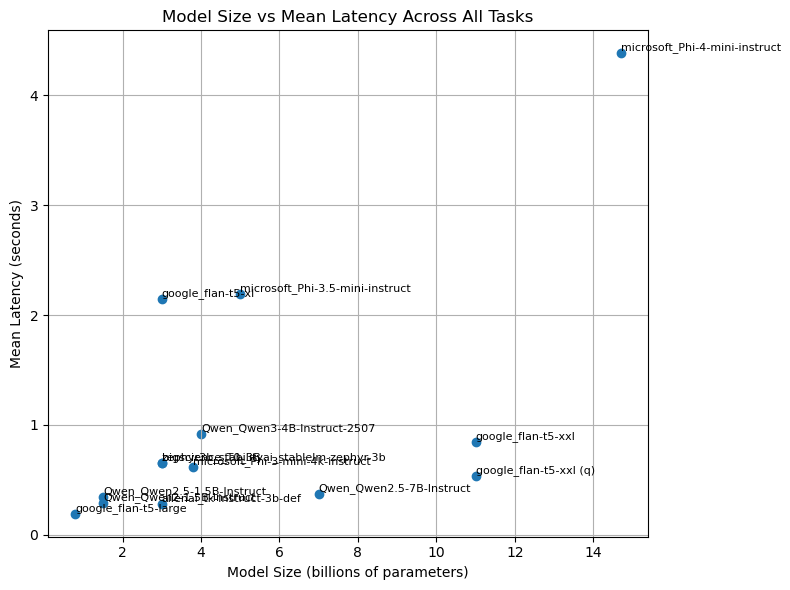

In [ ]:
import glob
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

METRICS_DIR = "final_metrics"  # adjust if needed
csv_paths = glob.glob(f"{METRICS_DIR}/task_metrics_*.csv")

dfs = []
for path in csv_paths:
    df = pd.read_csv(path)
    # If for some reason model_name is missing, infer from filename
    if "model_name" not in df.columns:
        model_name = (
            path.split("/")[-1]
            .replace("task_metrics_", "")
            .replace(".csv", "")
        )
        df["model_name"] = model_name
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(all_df)} rows from {len(csv_paths)} CSV files.")
print("Models found:", all_df["model_name"].unique())

MODEL_SIZES = {
    # AllenAI / BigScience
    "allenai_tk-instruct-3b-def": 3.0,
    "bigscience_T0_3B": 3.0,

    # FLAN-T5 family
    "google_flan-t5-large": 0.8,  
    "google_flan-t5-xl": 3.0,
    "google_flan-t5-xxl": 11.0,    
    "google_flan-t5-xxl_q": 11.0, 
    "google_flan-t5-xxl (q)": 11.0,    

    # Phi family (approx official sizes)
    "microsoft_Phi-3-mini-4k-instruct": 3.8,
    "microsoft_Phi-3.5-mini-instruct": 5.0,
    "microsoft_Phi-4-mini-instruct": 14.7,

    # Qwen family
    "Qwen_Qwen2-1.5B-Instruct": 1.5,
    "Qwen_Qwen2.5-1.5B-Instruct": 1.5,
    "Qwen_Qwen2.5-7B-Instruct": 7.0,
    "Qwen_Qwen3-4B-Instruct-2507": 4.0,

    # StableLM
    "zephyr3b_stabilityai_stablelm-zephyr-3b": 3.0,
}

all_df["model_size_b"] = all_df["model_name"].map(MODEL_SIZES)

unknown_models = sorted(all_df.loc[all_df["model_size_b"].isna(), "model_name"].unique())
if unknown_models:
    print("ERROR: Models without a size mapping:")
    for m in unknown_models:
        print(" ", repr(m))
else:
    print("PASS: All models have a size mapping.")

missing_cols = [c for c in ["avg_acc", "avg_latency"] if c not in all_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in all_df: {missing_cols}")

per_model = (
    all_df
    .dropna(subset=["avg_acc", "avg_latency"])
    .groupby("model_name")[["avg_acc", "avg_latency"]]
    .mean()
    .reset_index()
    .rename(columns={"avg_acc": "mean_accuracy", "avg_latency": "mean_latency"})
)

per_model["model_size_b"] = per_model["model_name"].map(MODEL_SIZES)

print("\nPer-model mean accuracy, latency, and size:")
print(per_model)

# (a) Model size vs mean accuracy
rho_size_acc, p_size_acc = spearmanr(
    per_model["model_size_b"],
    per_model["mean_accuracy"]
)

# (b) Model size vs mean latency
rho_size_lat, p_size_lat = spearmanr(
    per_model["model_size_b"],
    per_model["mean_latency"]
)

print("\nSpearman correlation (model size vs mean accuracy):")
print("  rho =", rho_size_acc)
print("  p   =", p_size_acc)

print("\nSpearman correlation (model size vs mean latency):")
print("  rho =", rho_size_lat)
print("  p   =", p_size_lat)

plt.figure(figsize=(8, 6))
plt.scatter(per_model["model_size_b"], per_model["mean_accuracy"])

for _, row in per_model.iterrows():
    label = row["model_name"]
    plt.text(
        row["model_size_b"],
        row["mean_accuracy"],
        label,
        fontsize=8,
        ha="left",
        va="bottom",
    )

plt.title("Model Size vs Mean Accuracy Across All Tasks")
plt.xlabel("Model Size (billions of parameters)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(per_model["model_size_b"], per_model["mean_latency"])

for _, row in per_model.iterrows():
    label = row["model_name"]
    plt.text(
        row["model_size_b"],
        row["mean_latency"],
        label,
        fontsize=8,
        ha="left",
        va="bottom",
    )

plt.title("Model Size vs Mean Latency Across All Tasks")
plt.xlabel("Model Size (billions of parameters)")
plt.ylabel("Mean Latency (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()



Spearman correlation (mean accuracy vs mean latency, per model):
  rho = -0.2879120879120879
  p   = 0.3181928710258003


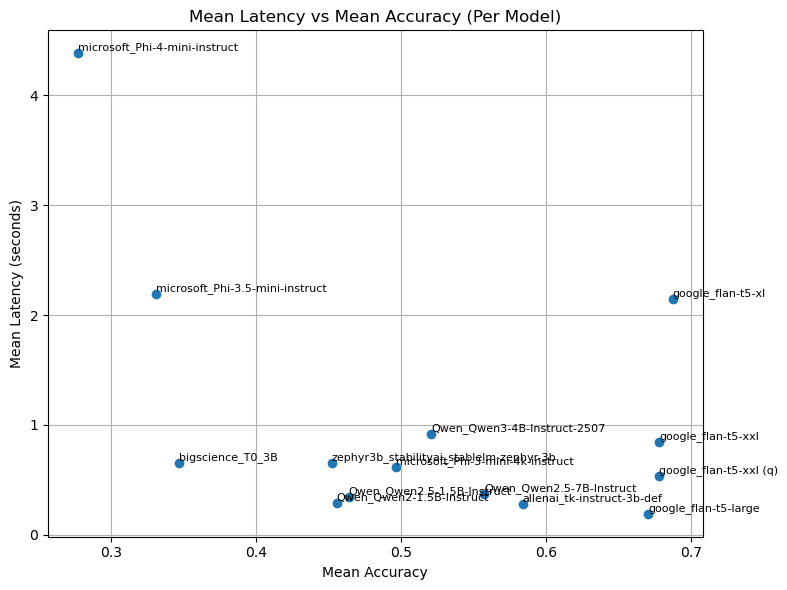

In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

rho_acc_lat, p_acc_lat = spearmanr(
    per_model["mean_accuracy"],
    per_model["mean_latency"]
)

print("\nSpearman correlation (mean accuracy vs mean latency, per model):")
print("  rho =", rho_acc_lat)
print("  p   =", p_acc_lat)

plt.figure(figsize=(8, 6))
plt.scatter(per_model["mean_accuracy"], per_model["mean_latency"])

for _, row in per_model.iterrows():
    label = row["model_name"]
    plt.text(
        row["mean_accuracy"],
        row["mean_latency"],
        label,
        fontsize=8,
        ha="left",
        va="bottom",
    )

plt.title("Mean Latency vs Mean Accuracy (Per Model)")
plt.xlabel("Mean Accuracy")
plt.ylabel("Mean Latency (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()



GLOBAL Spearman correlation (accuracy vs latency, all task-model points):
  rho = -0.3137533574962913
  p   = 8.932793556043298e-241


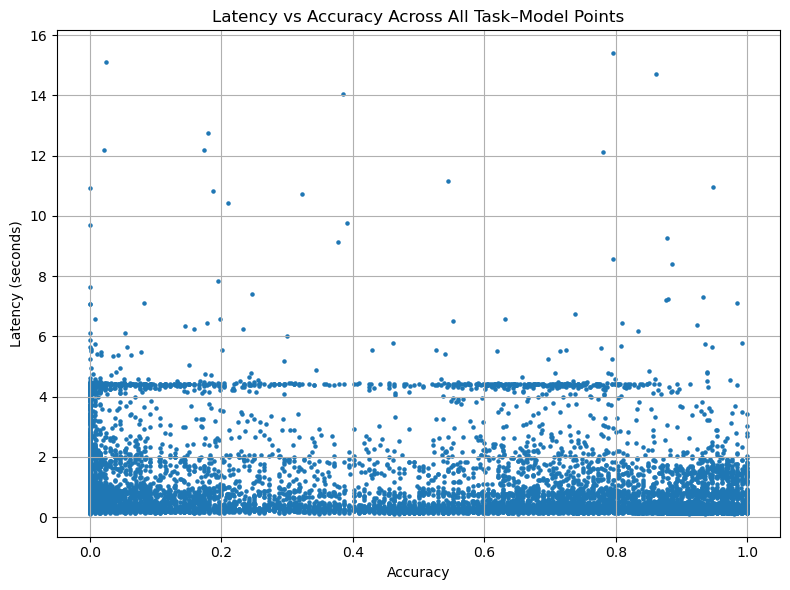

In [8]:
# Global correlation across all task-model pairs
rho_global_acc_lat, p_global_acc_lat = spearmanr(
    all_df["avg_acc"],
    all_df["avg_latency"]
)

print("\nGLOBAL Spearman correlation (accuracy vs latency, all task-model points):")
print("  rho =", rho_global_acc_lat)
print("  p   =", p_global_acc_lat)

plt.figure(figsize=(8, 6))
plt.scatter(all_df["avg_acc"], all_df["avg_latency"], s=5)
plt.title("Latency vs Accuracy Across All Task–Model Points")
plt.xlabel("Accuracy")
plt.ylabel("Latency (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_6587/1113319626.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


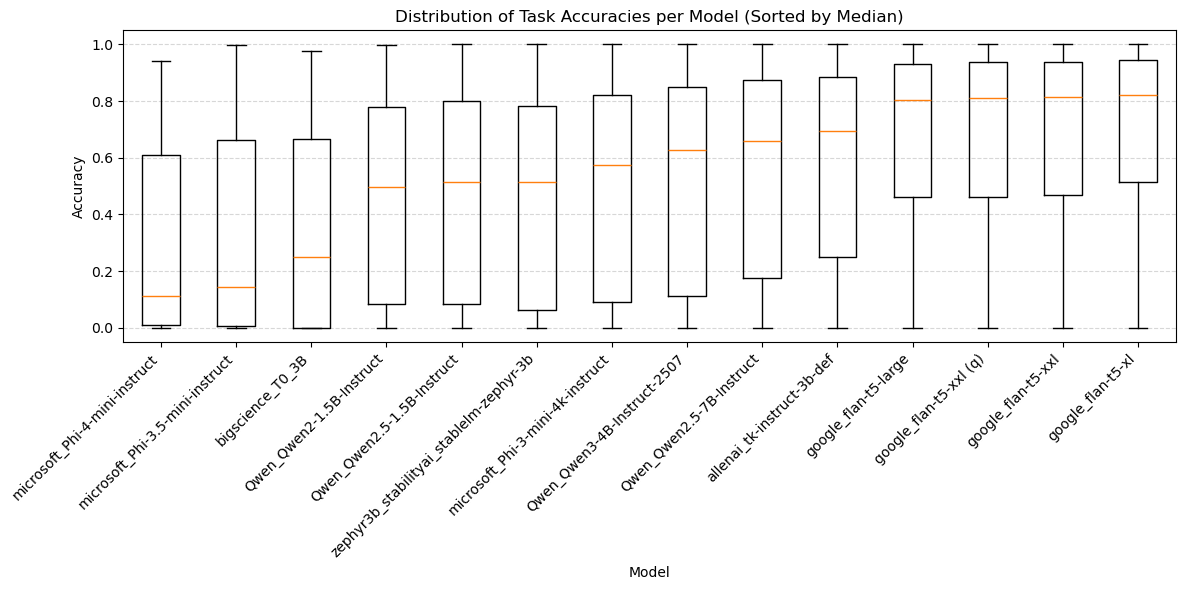

In [9]:
import numpy as np
import matplotlib.pyplot as plt

df_acc = all_df.dropna(subset=["avg_acc"])

# Compute median accuracy per model
medians = (
    df_acc.groupby("model_name")["avg_acc"]
    .median()
    .sort_values()
)

models_sorted = medians.index.tolist()

data_per_model_sorted = [
    df_acc.loc[df_acc["model_name"] == m, "avg_acc"].values
    for m in models_sorted
]

plt.figure(figsize=(12, 6))
plt.boxplot(
    data_per_model_sorted,
    labels=models_sorted,
    showfliers=True,
    vert=True
)

plt.title("Distribution of Task Accuracies per Model (Sorted by Median)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Found 60 categories


/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


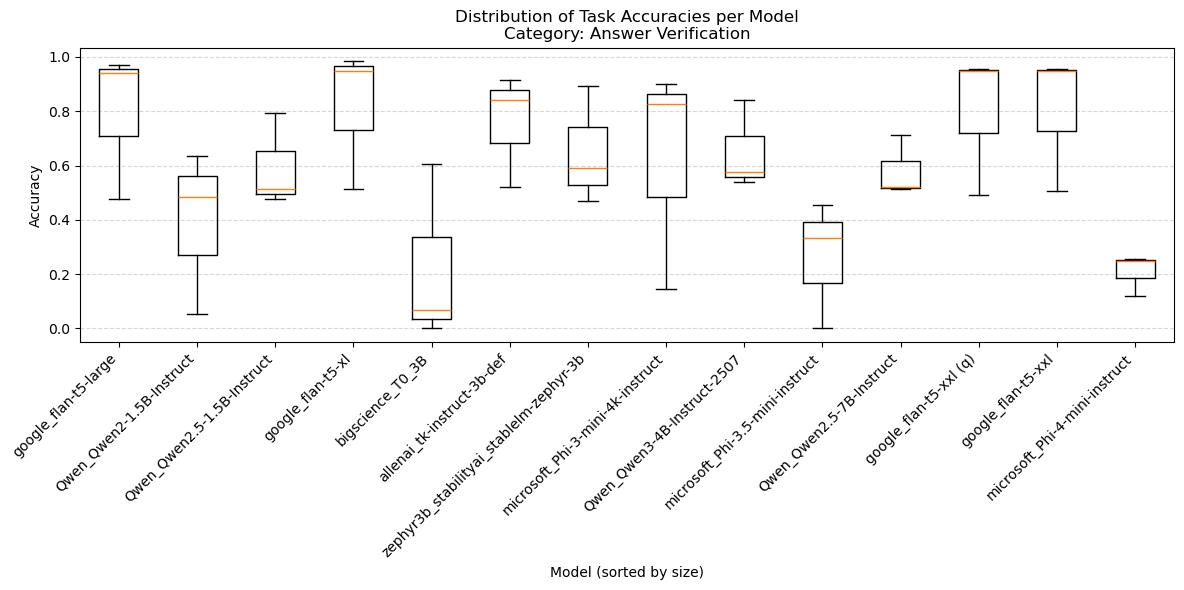

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


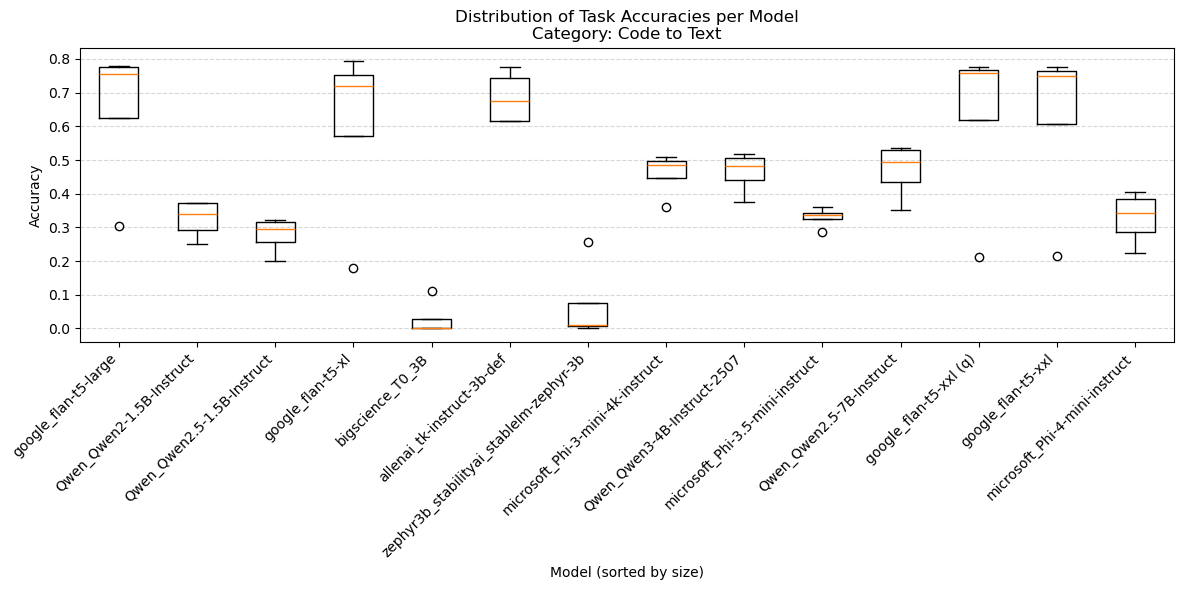

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


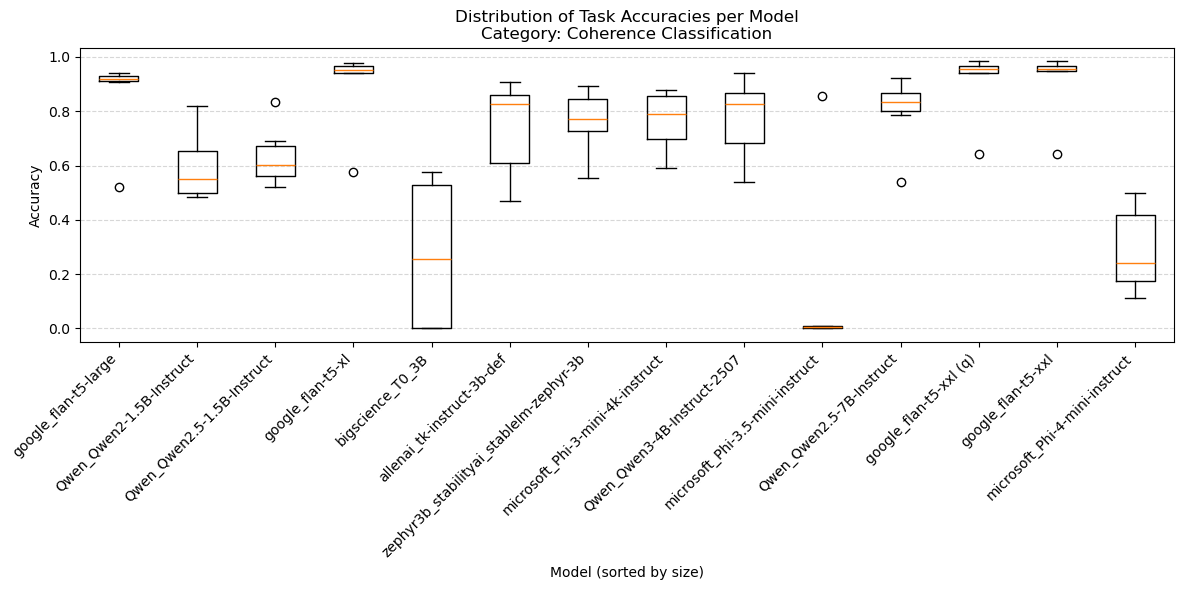

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


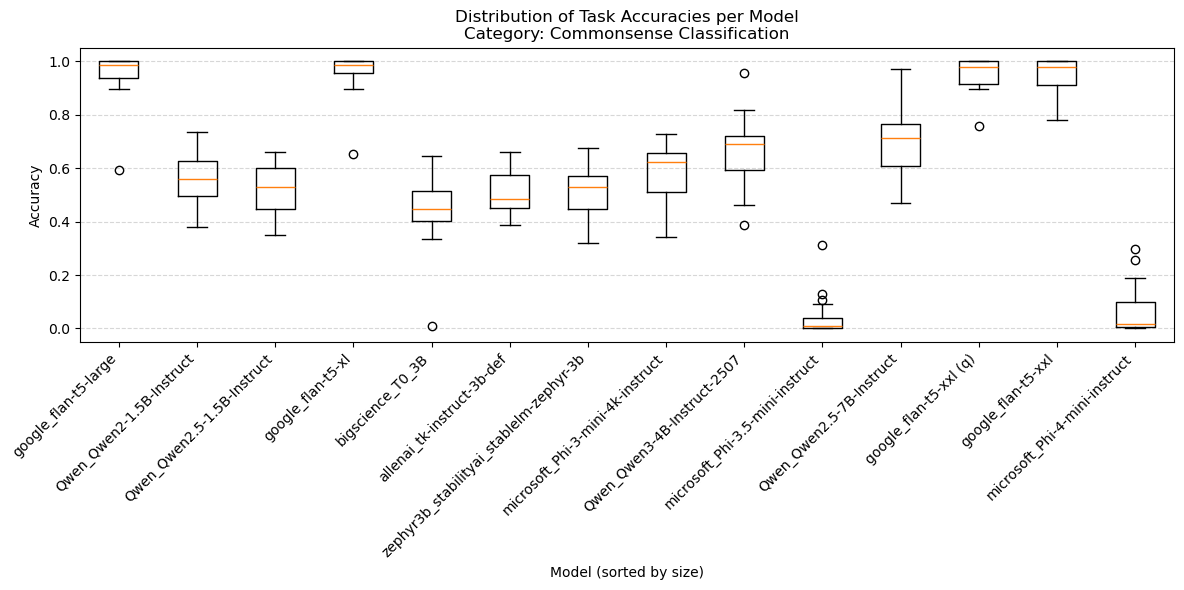

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


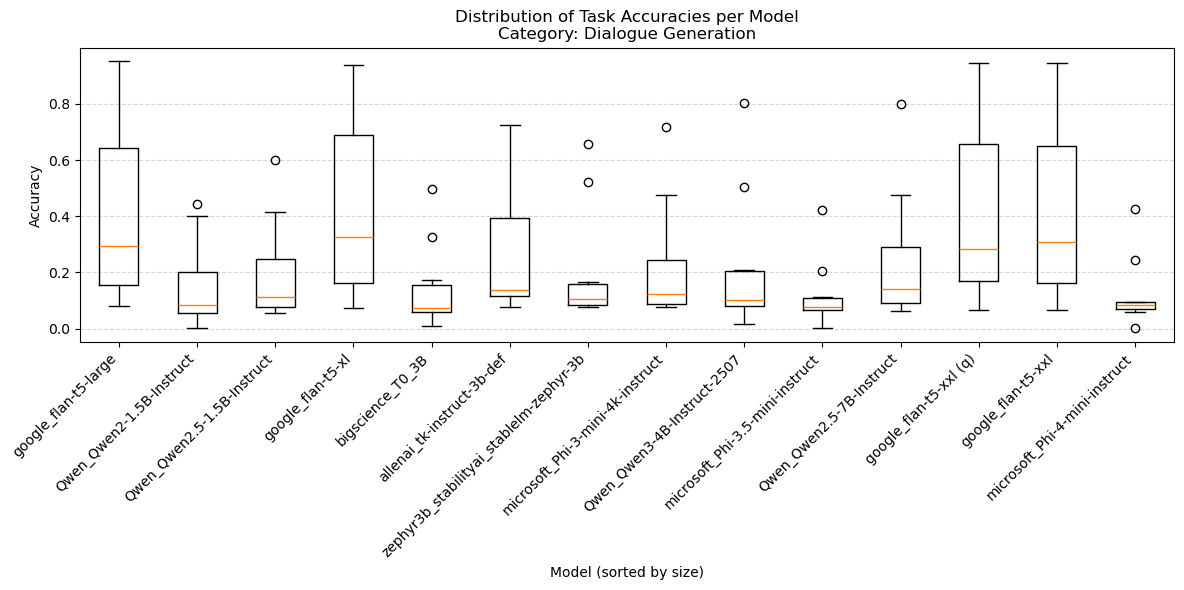

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


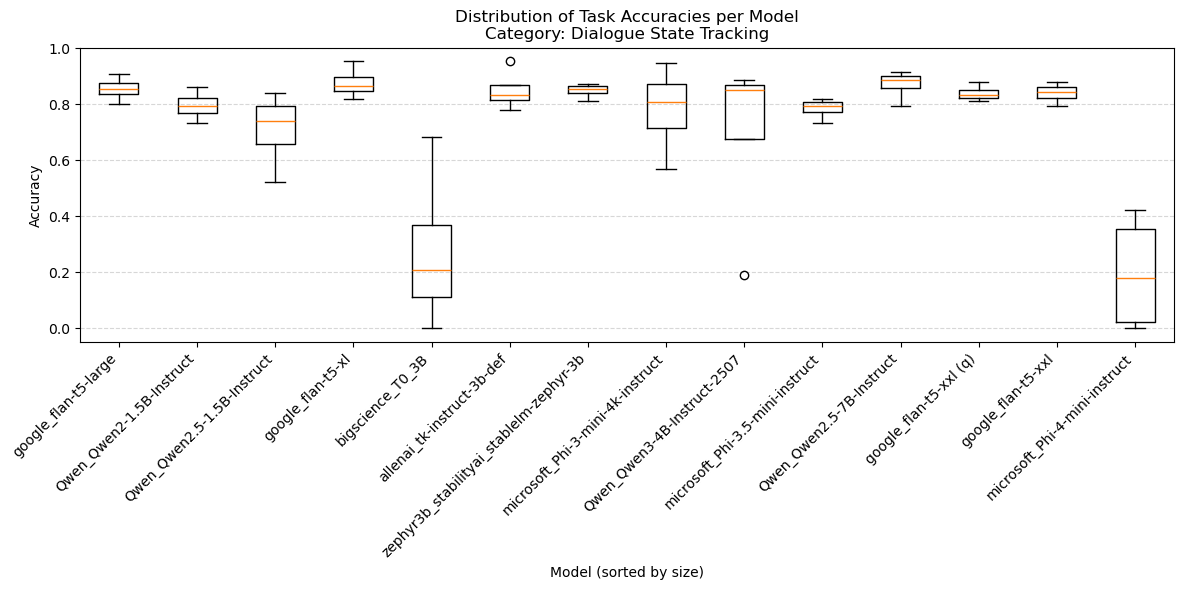

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


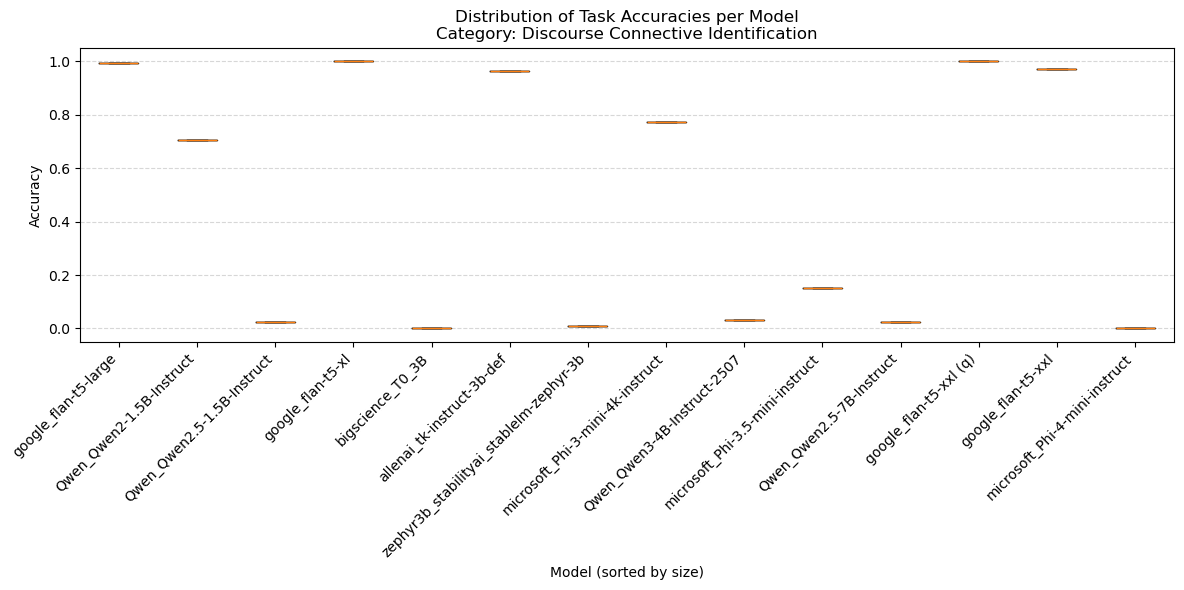

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


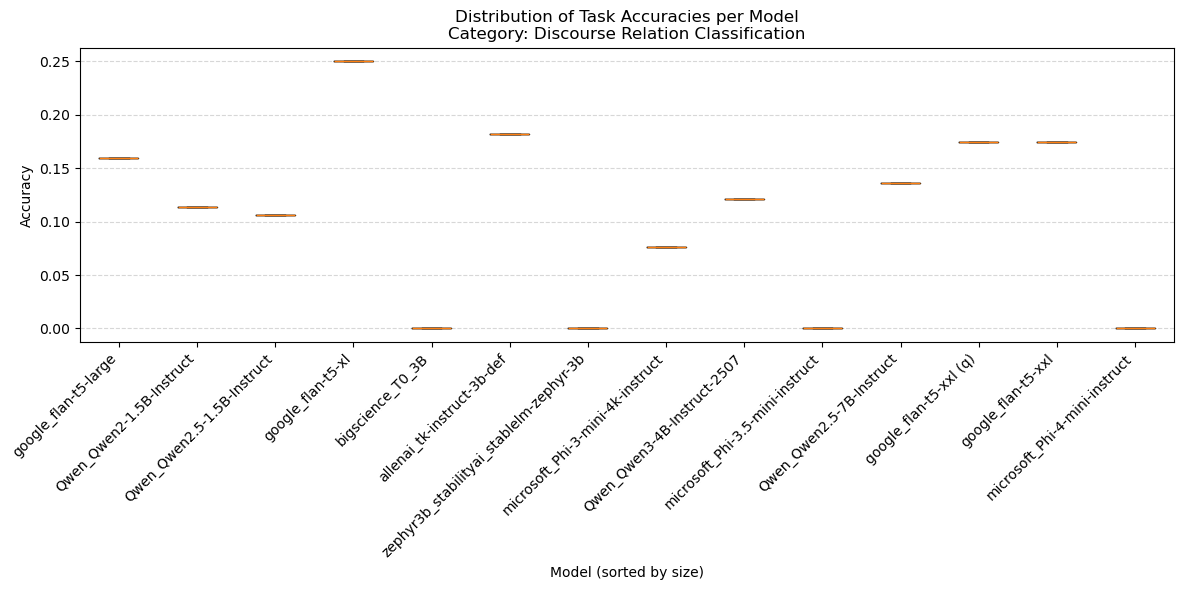

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


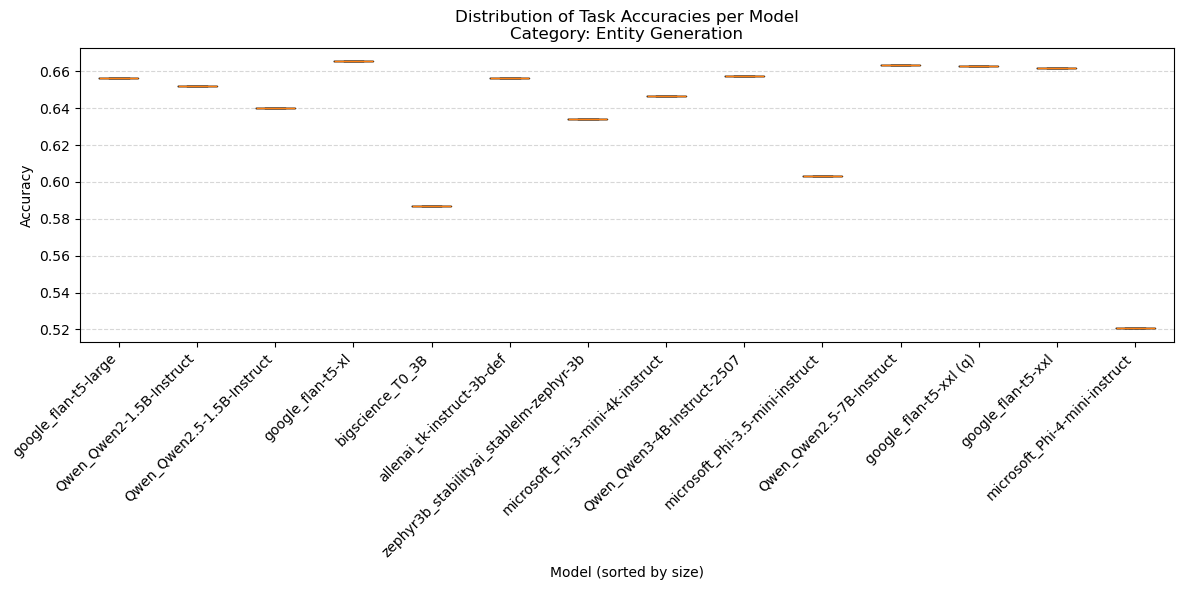

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


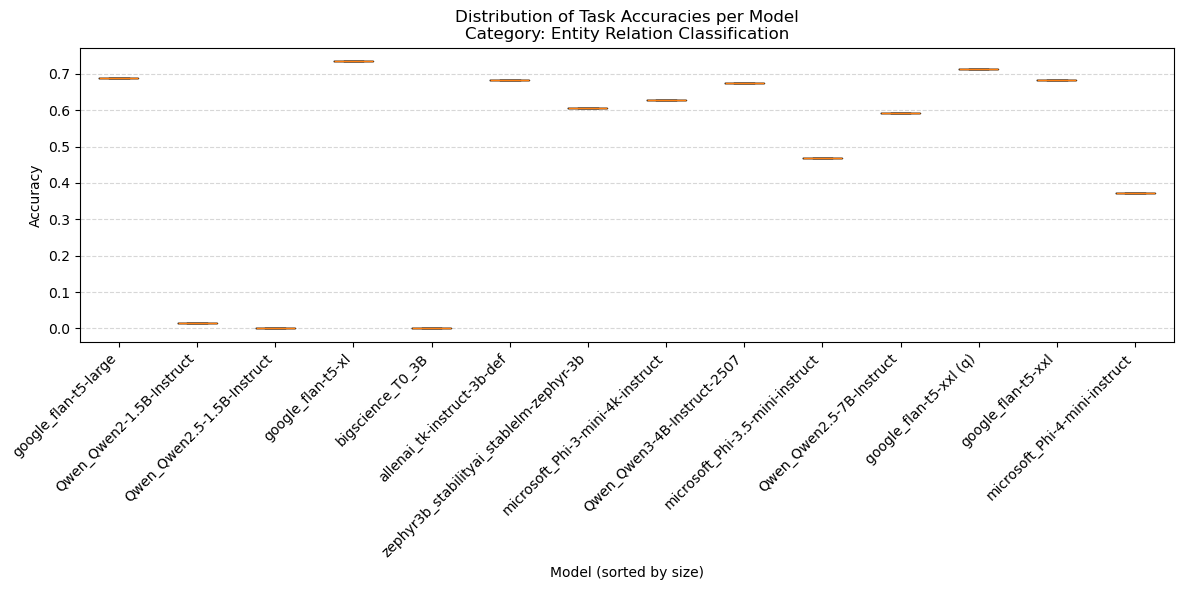

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


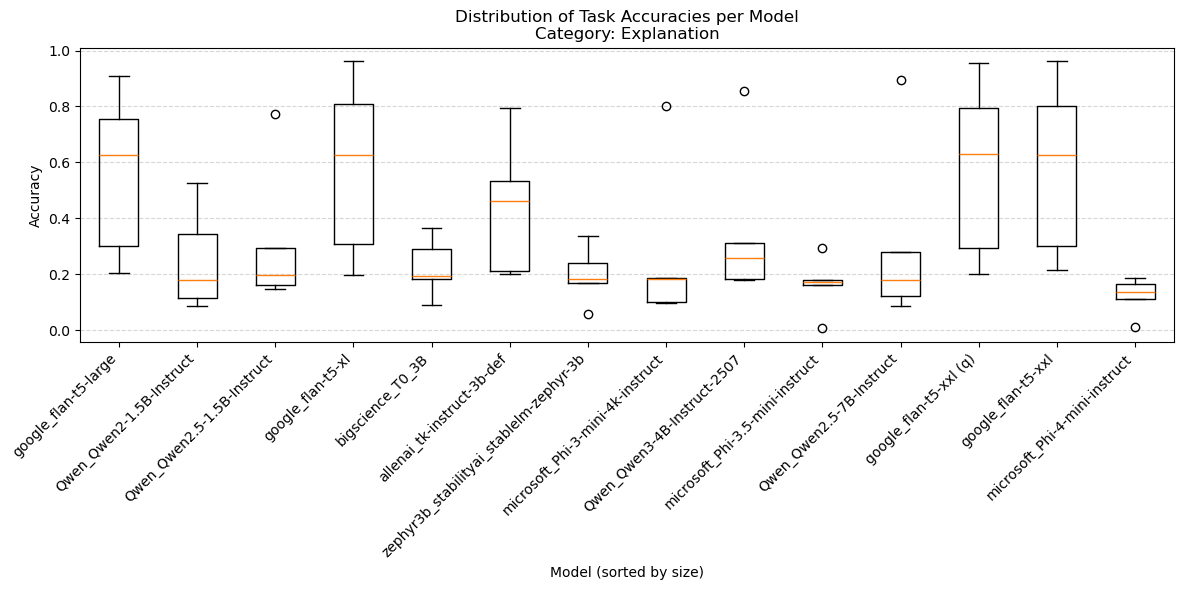

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


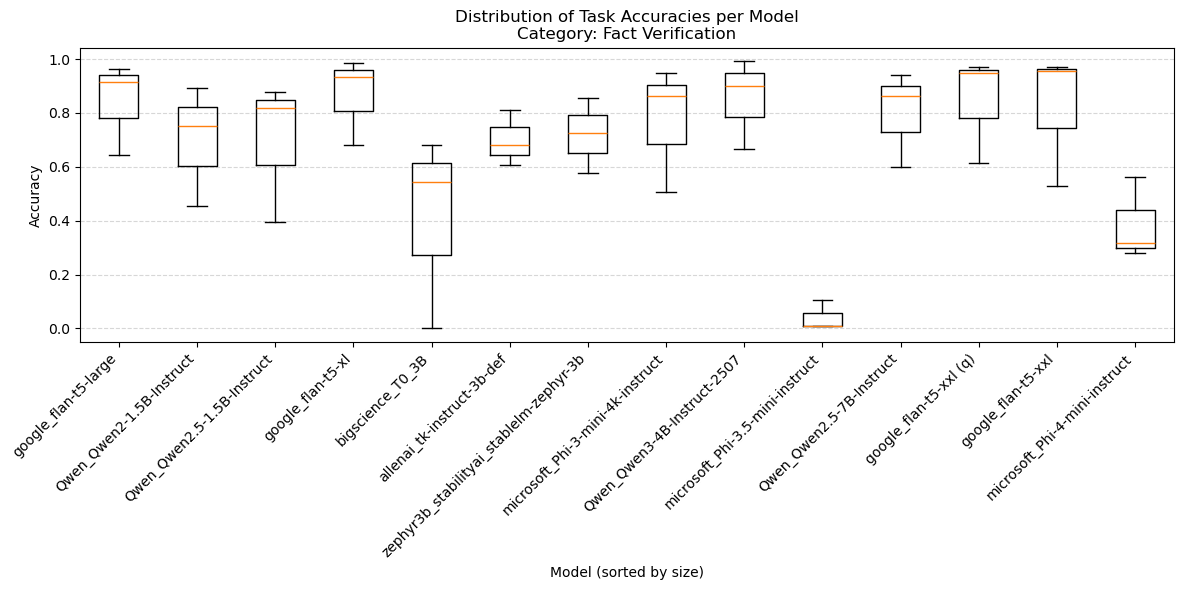

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


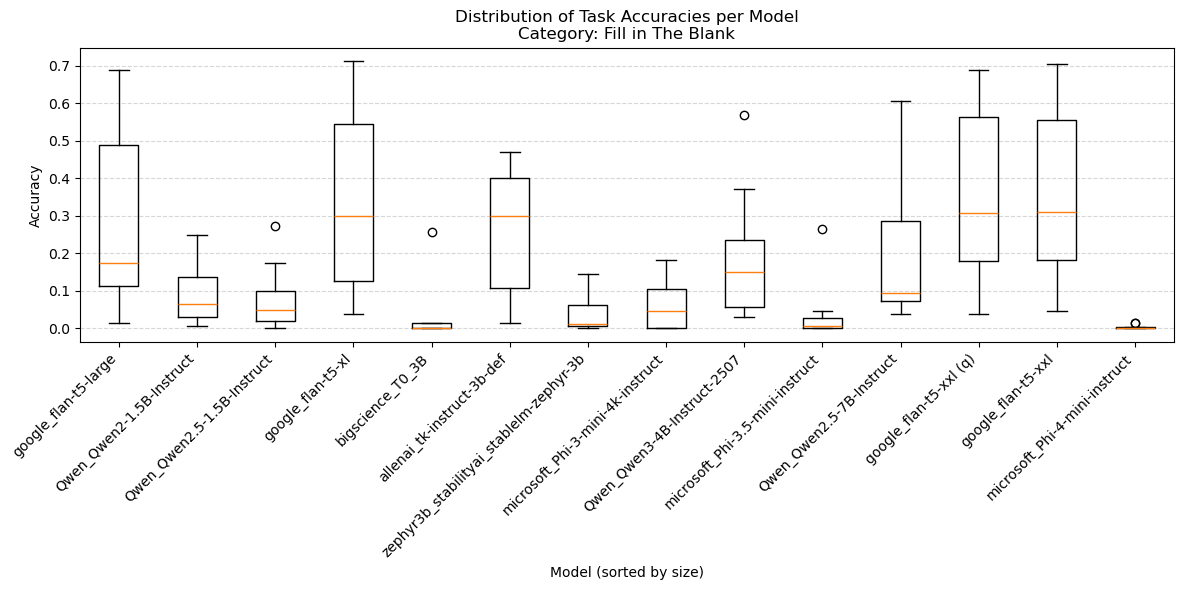

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


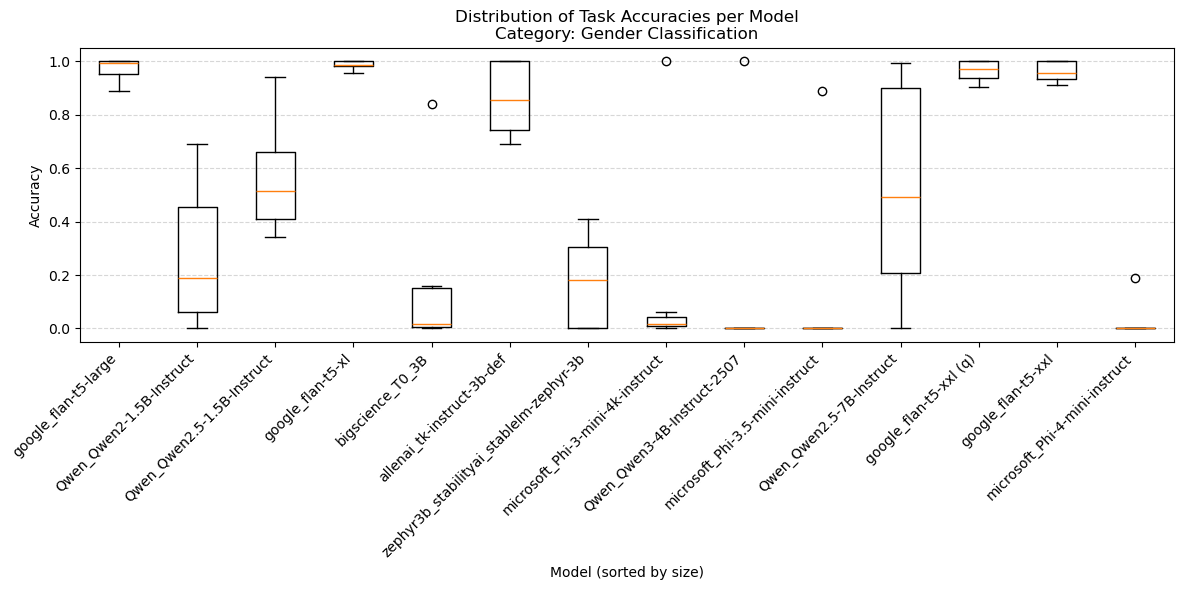

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


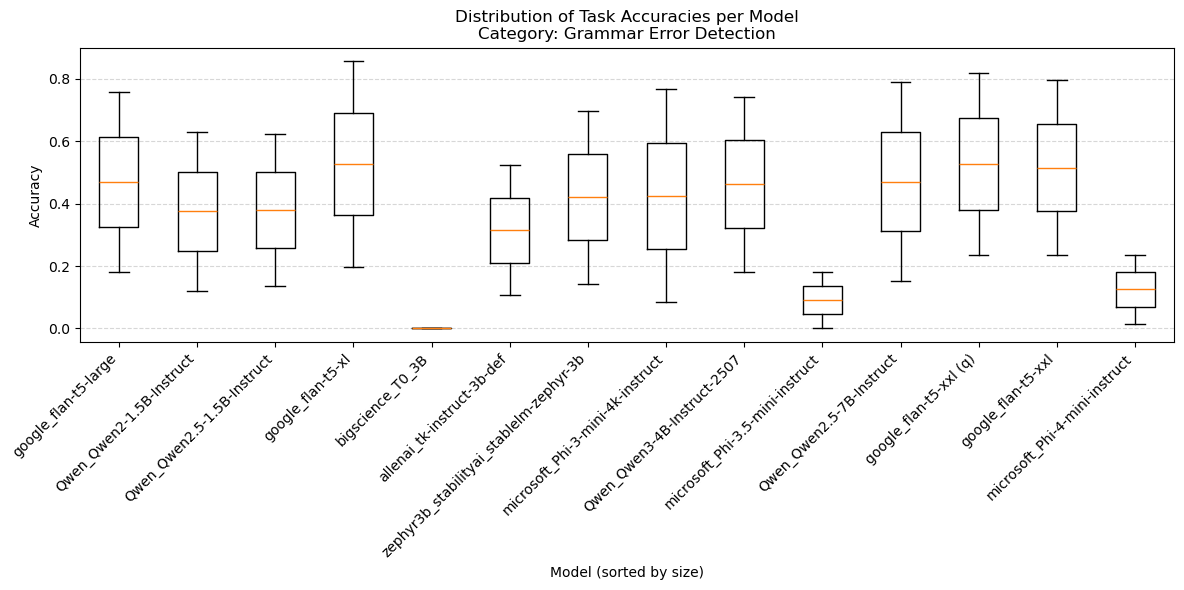

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


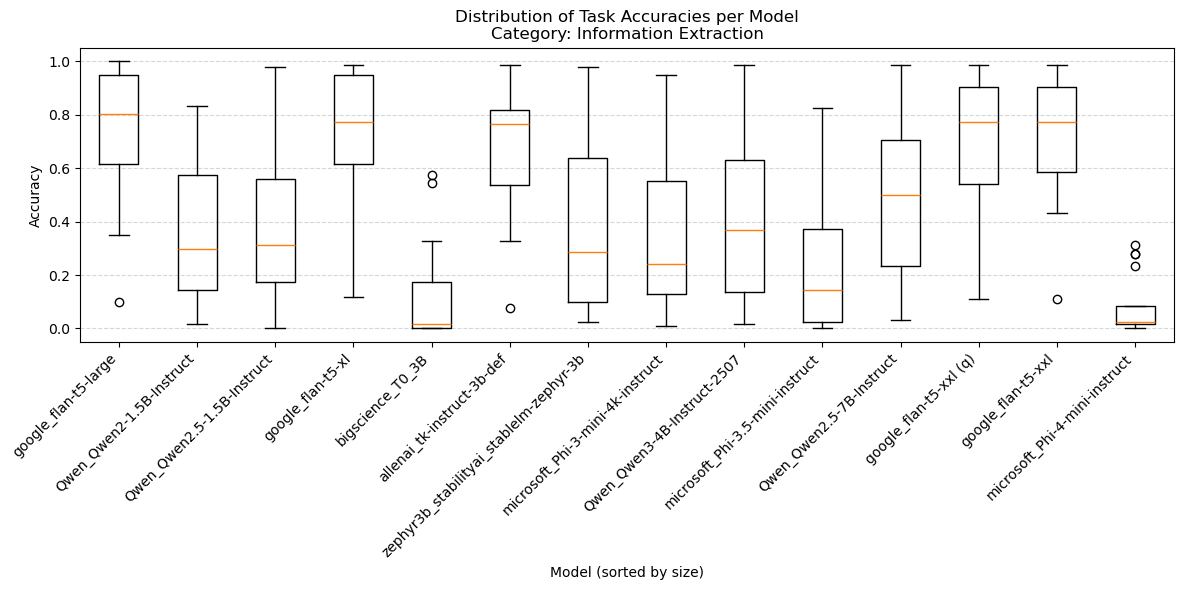

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


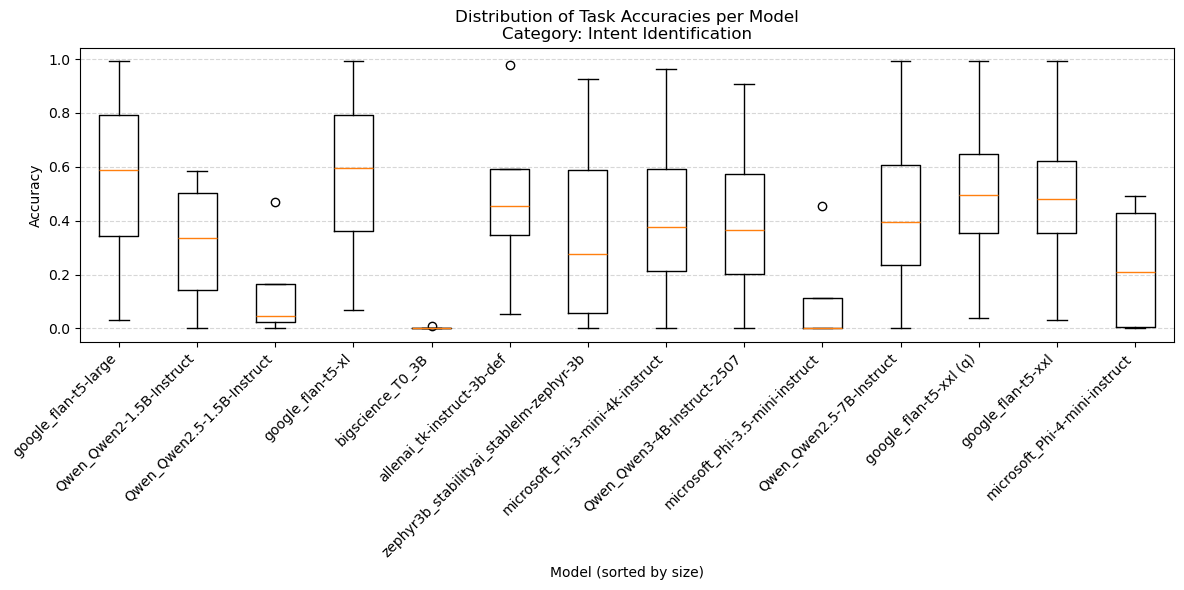

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


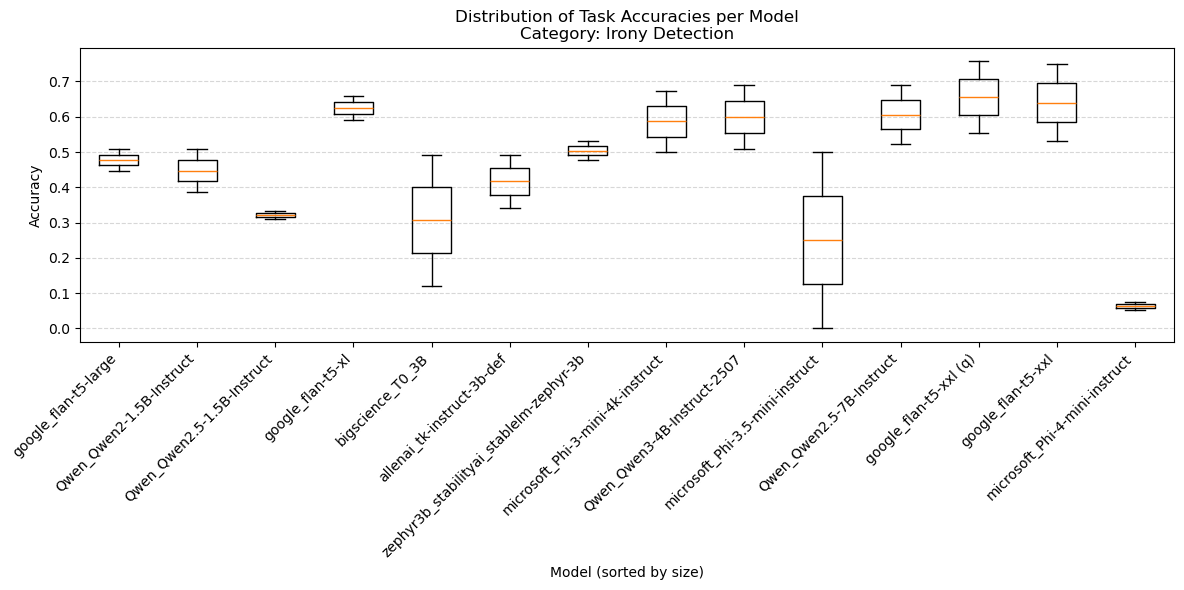

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


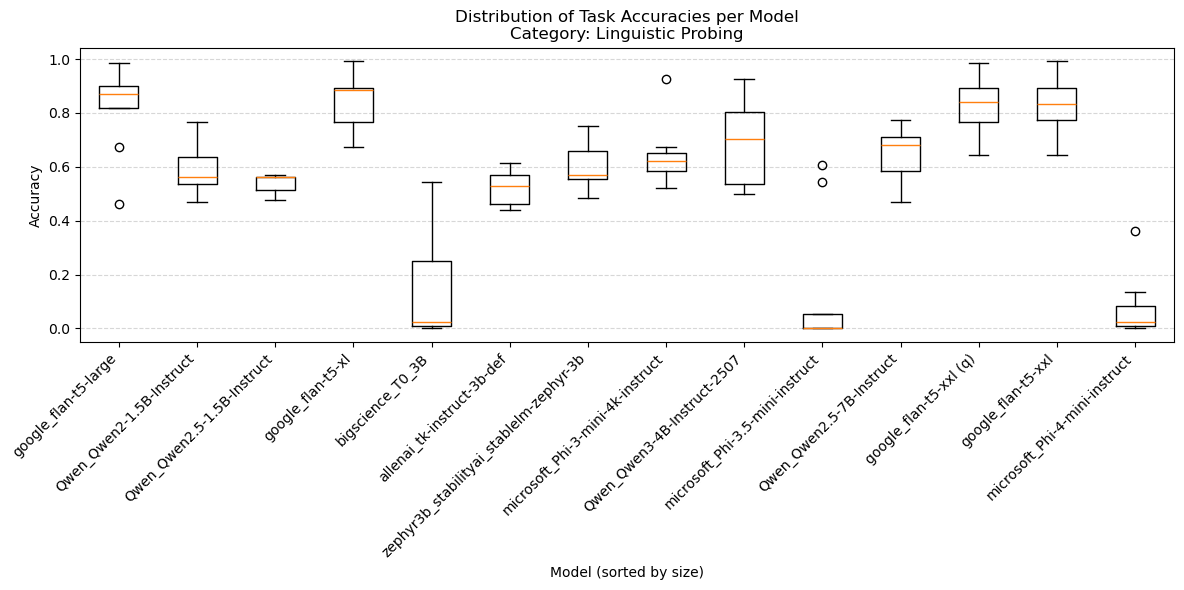

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


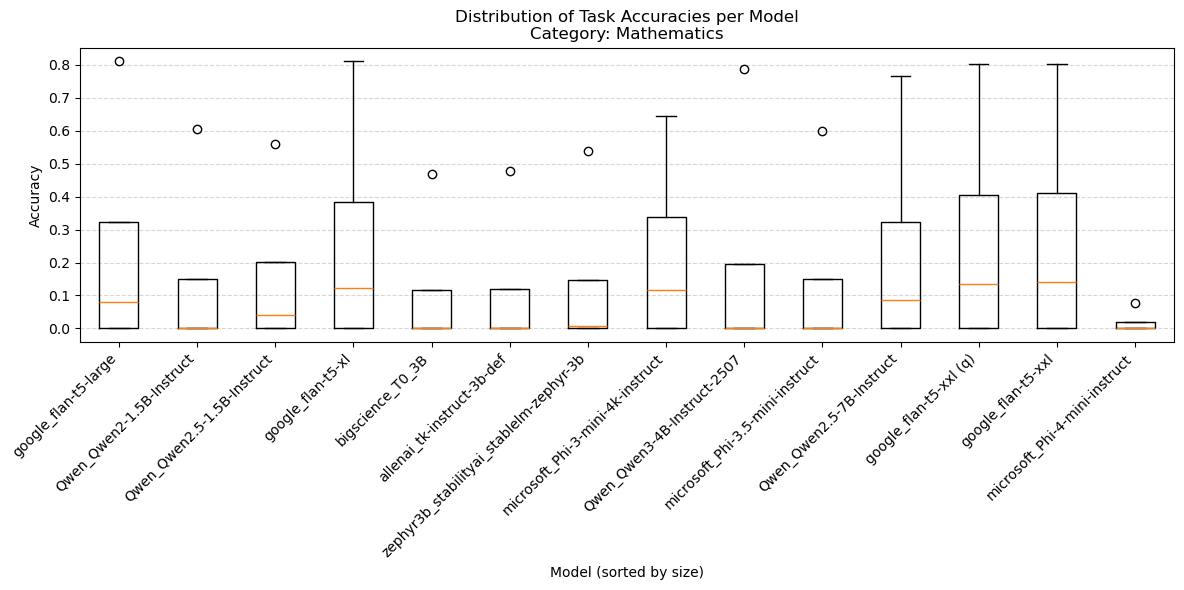

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


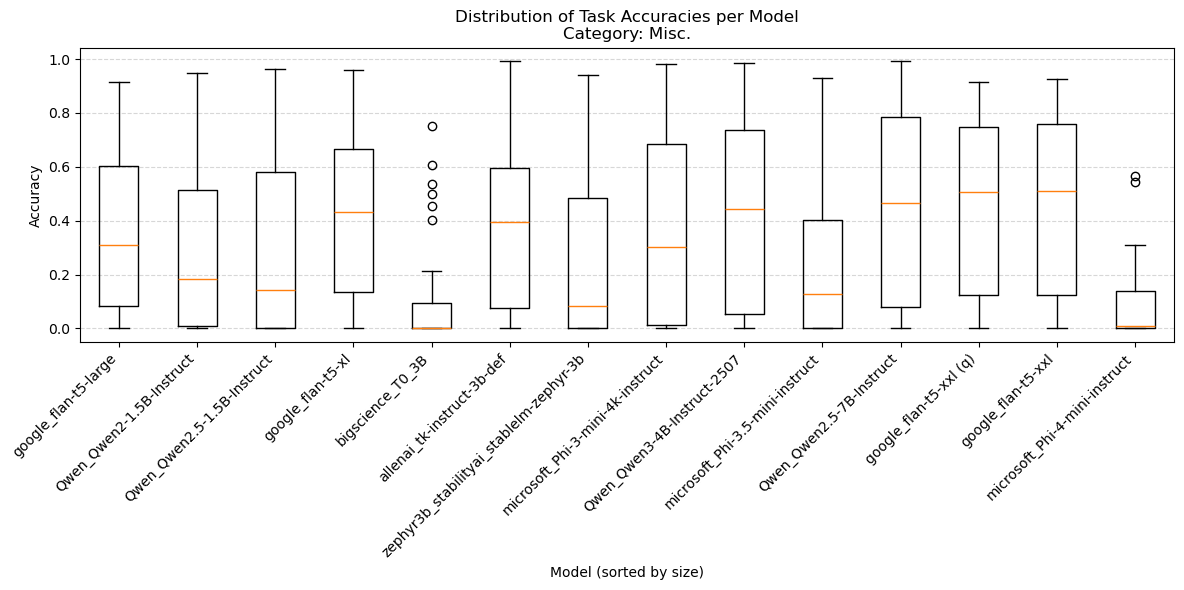

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


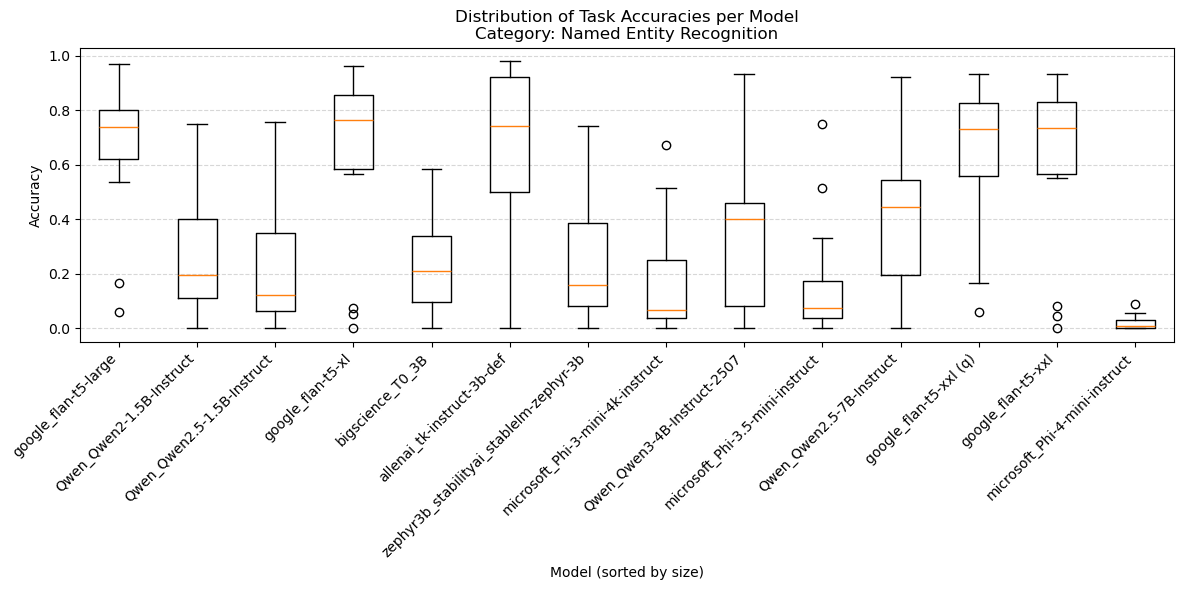

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


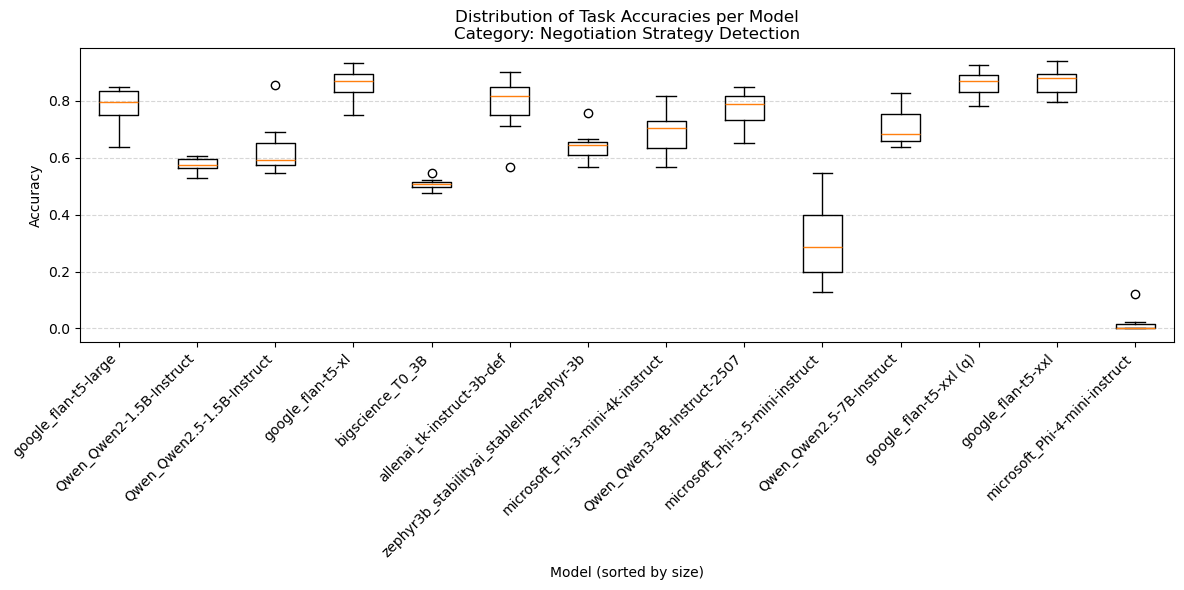

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


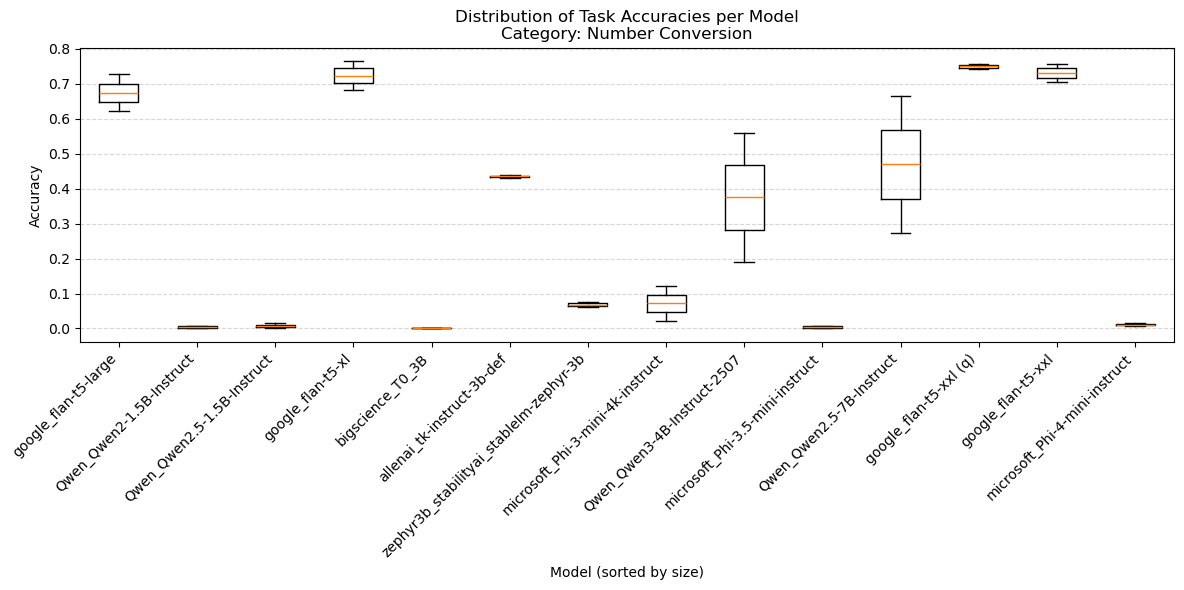

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


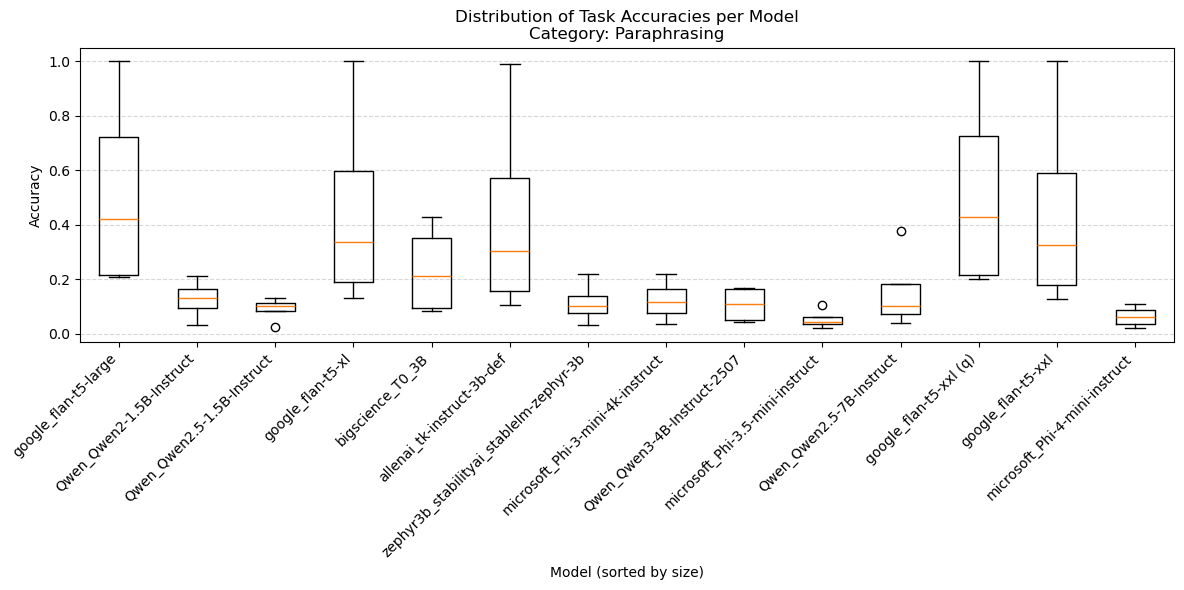

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


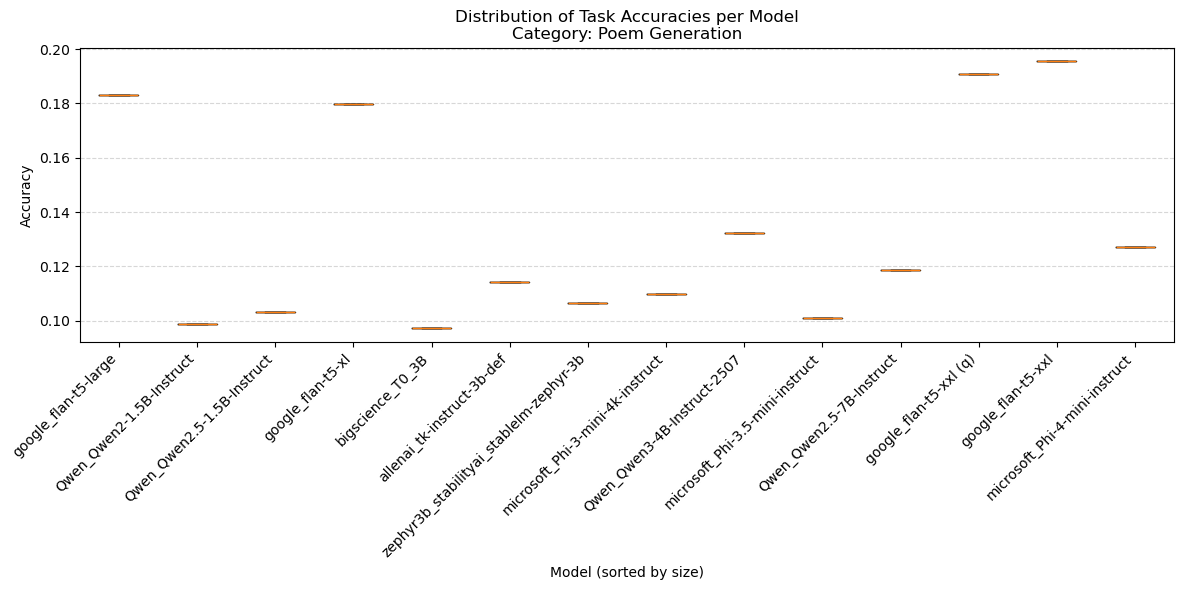

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


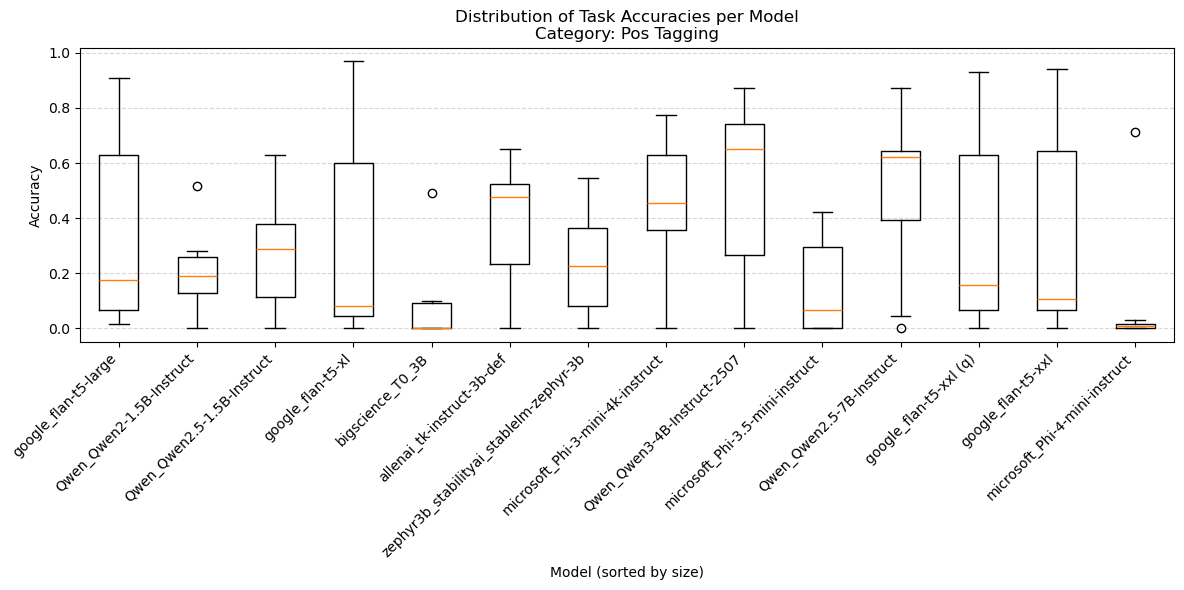

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


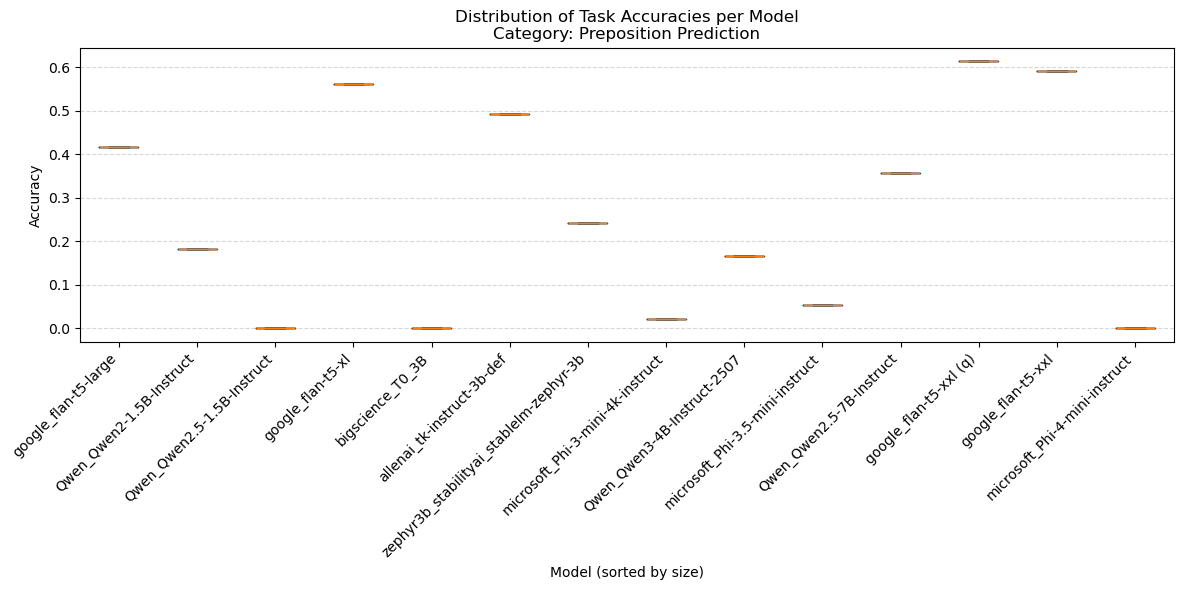

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


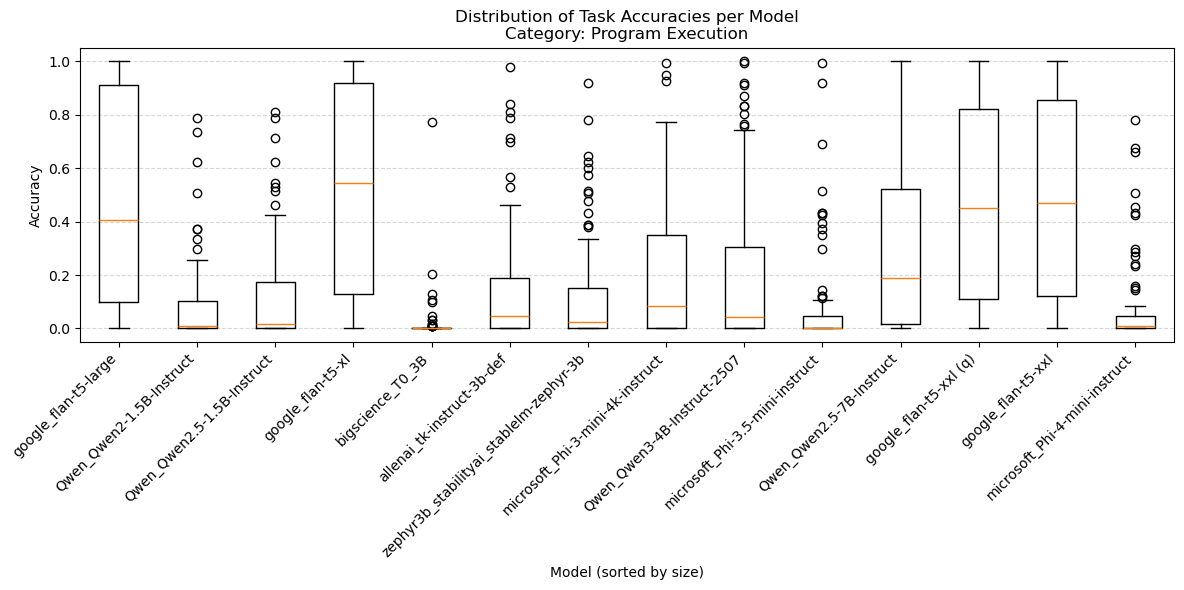

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


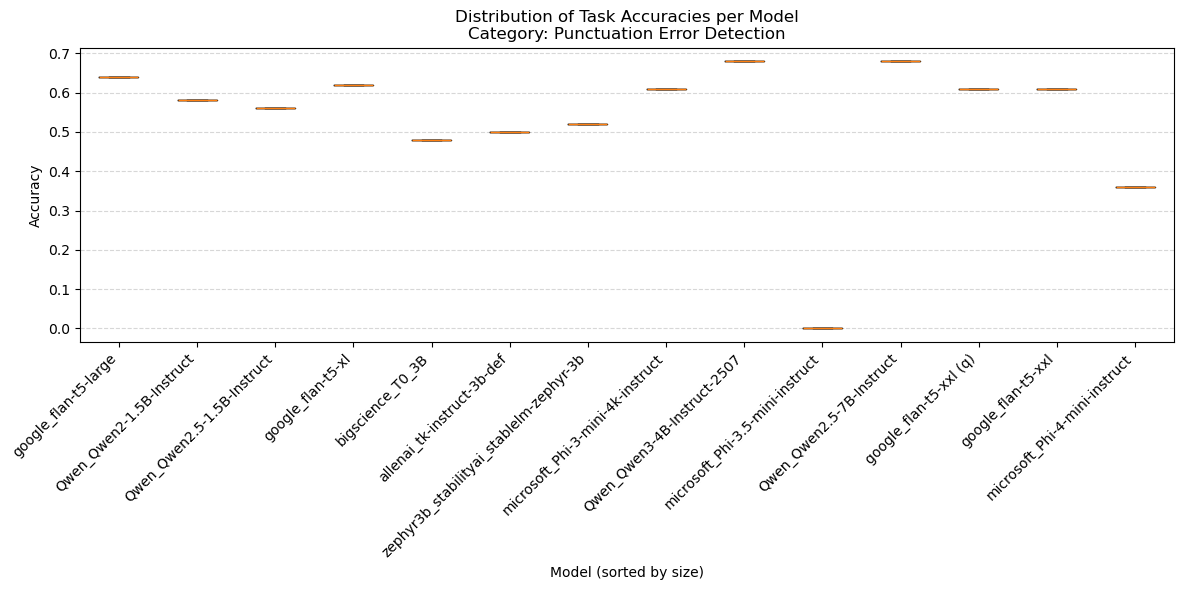

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


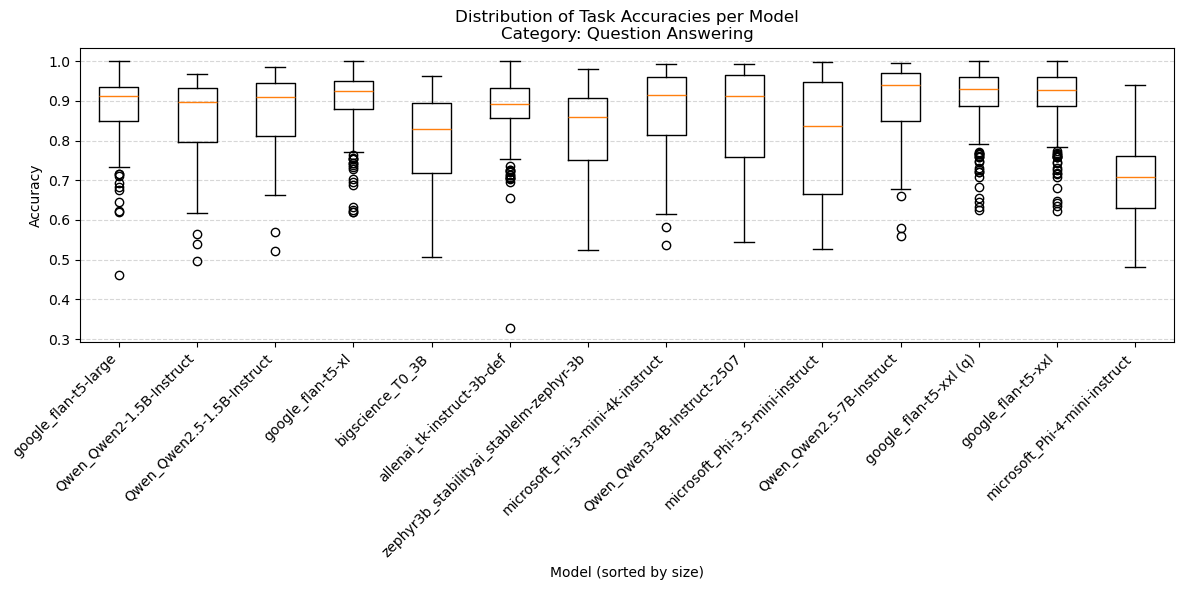

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


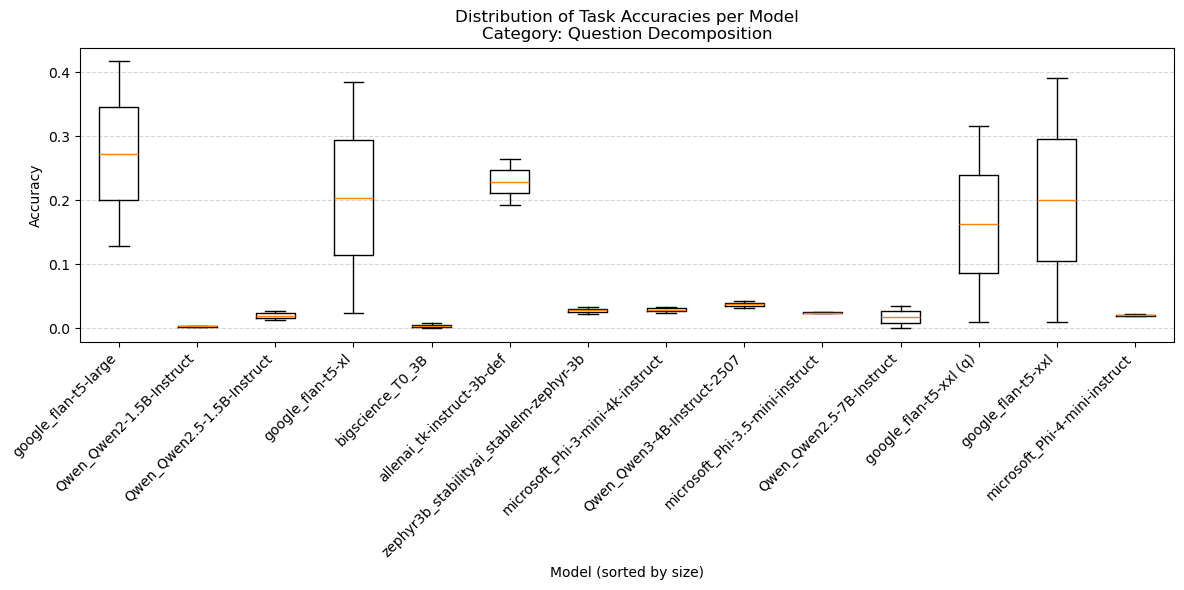

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


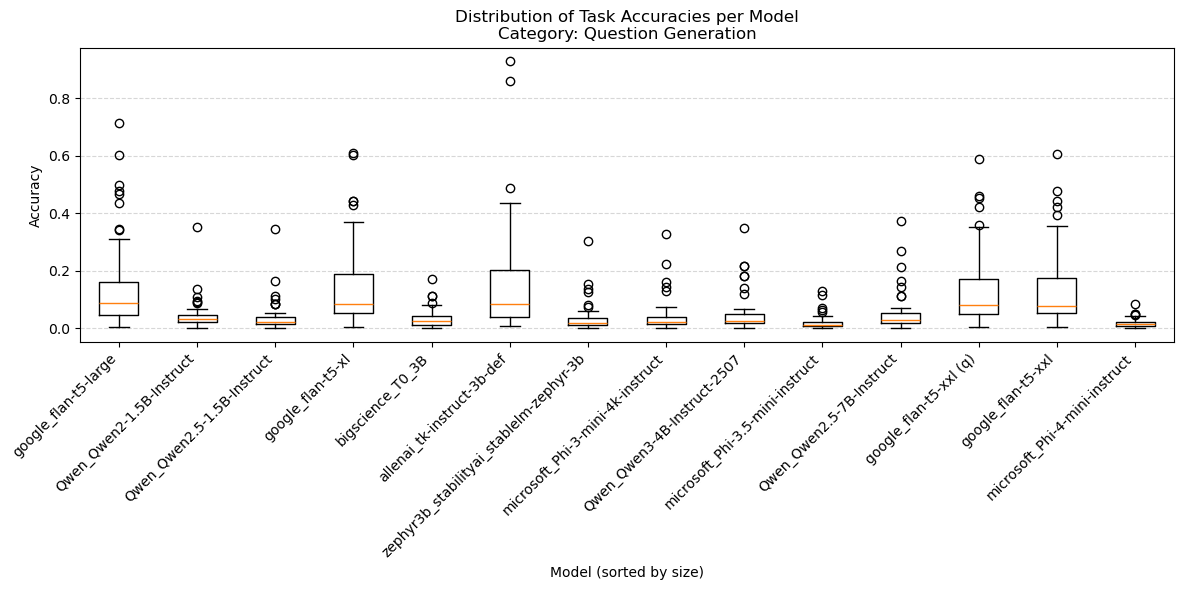

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


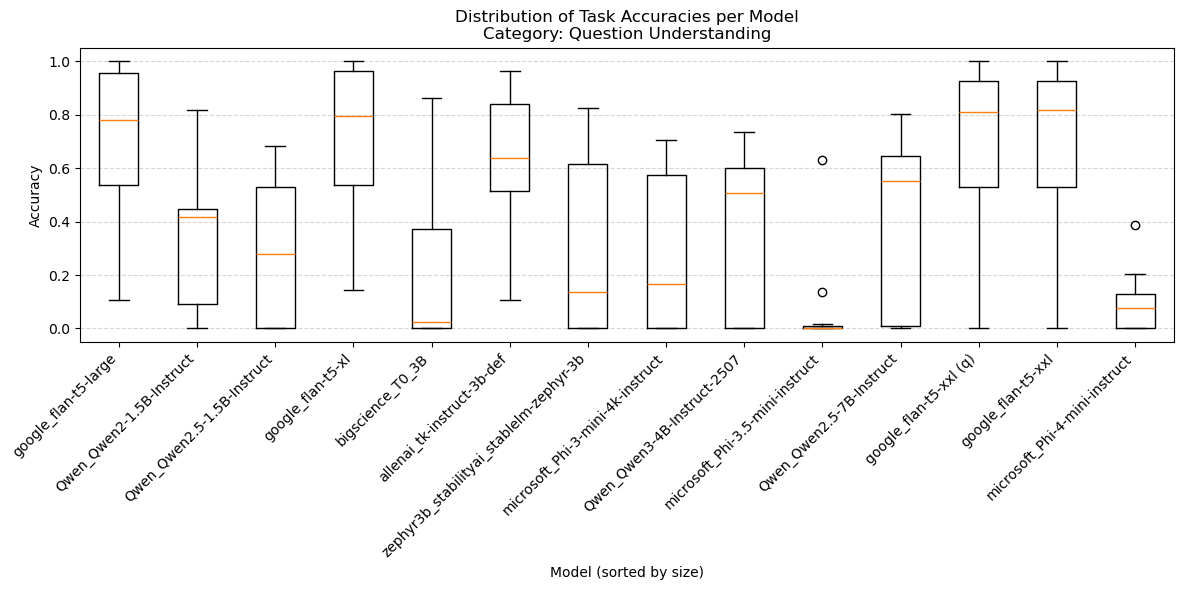

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


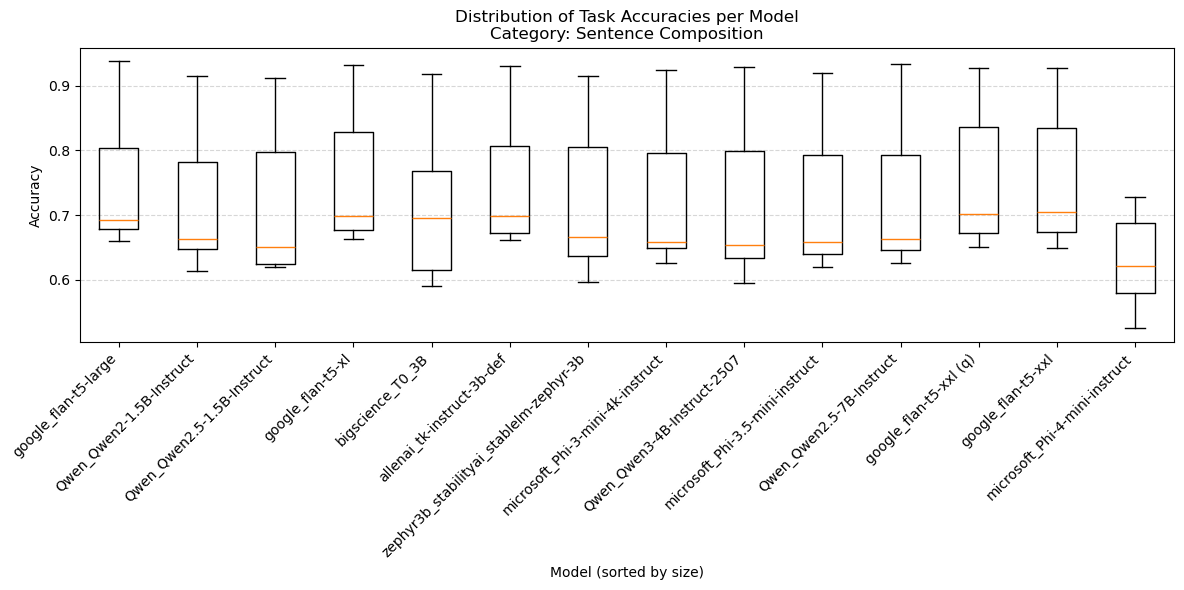

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


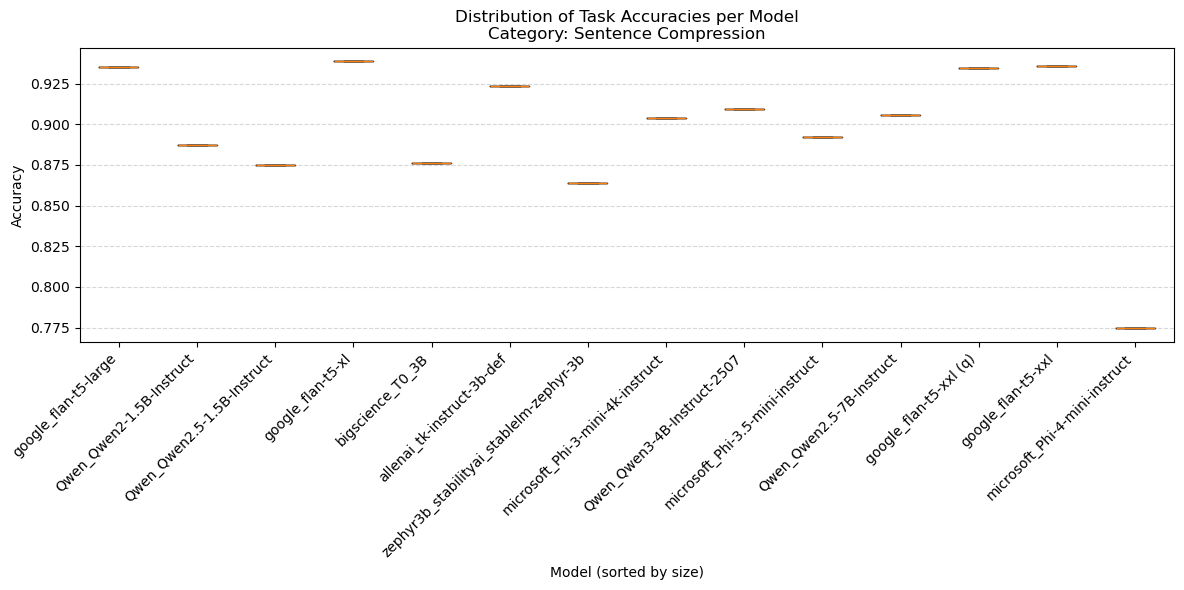

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


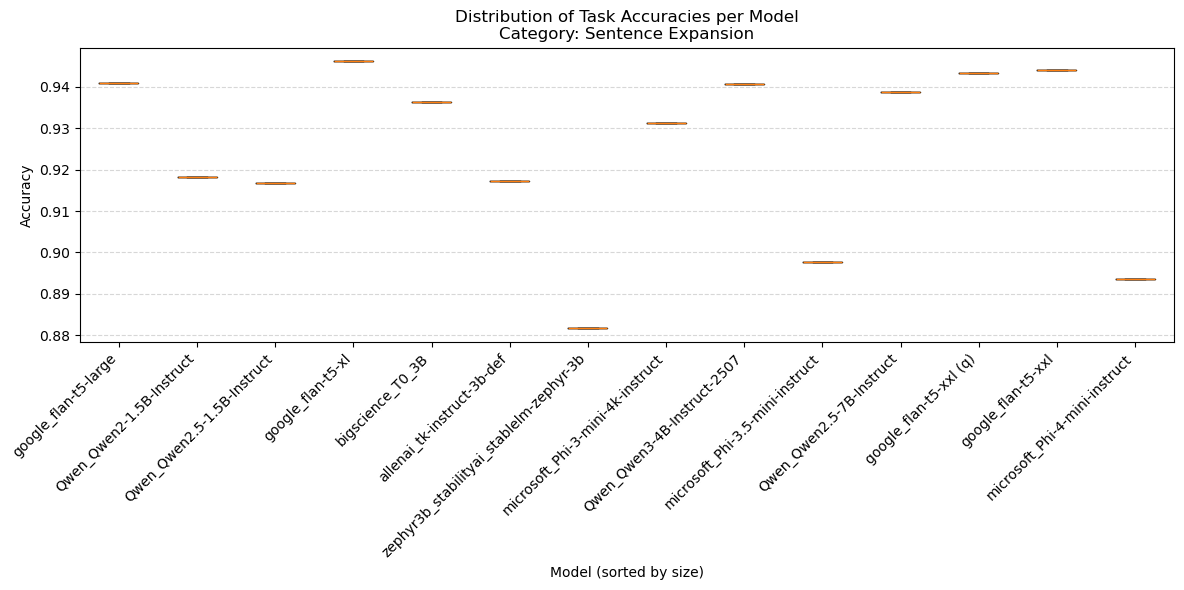

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


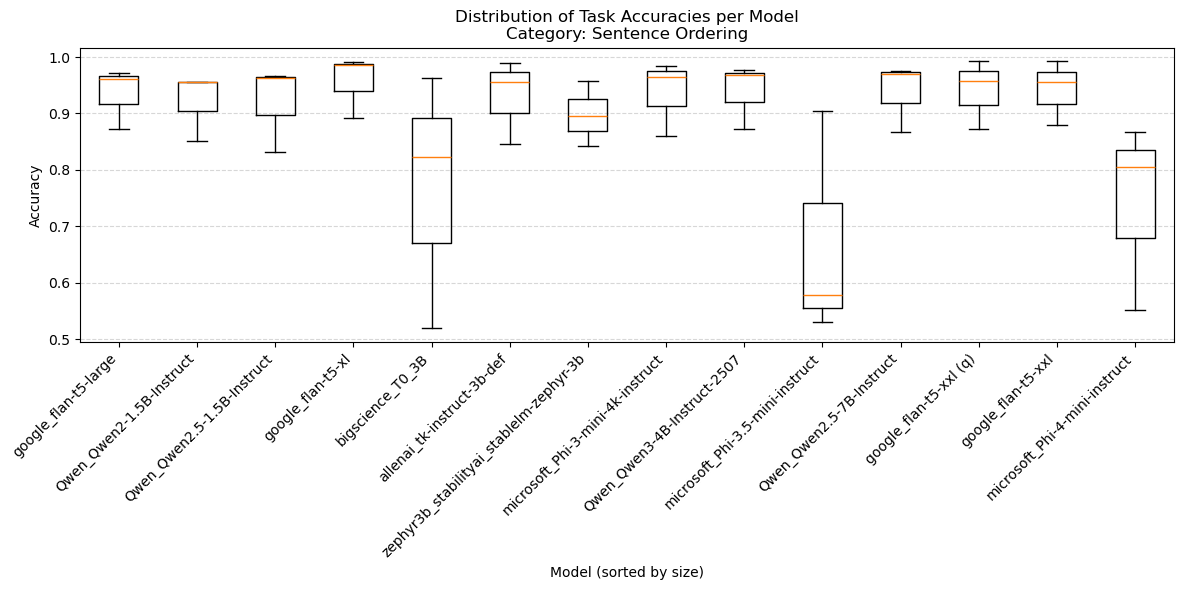

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


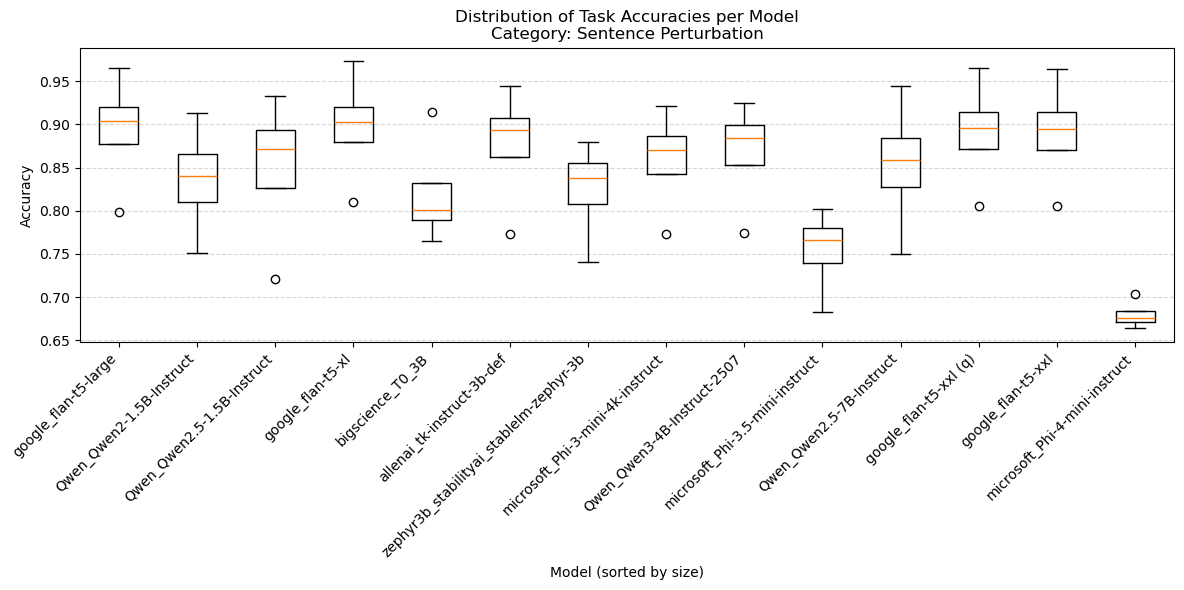

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


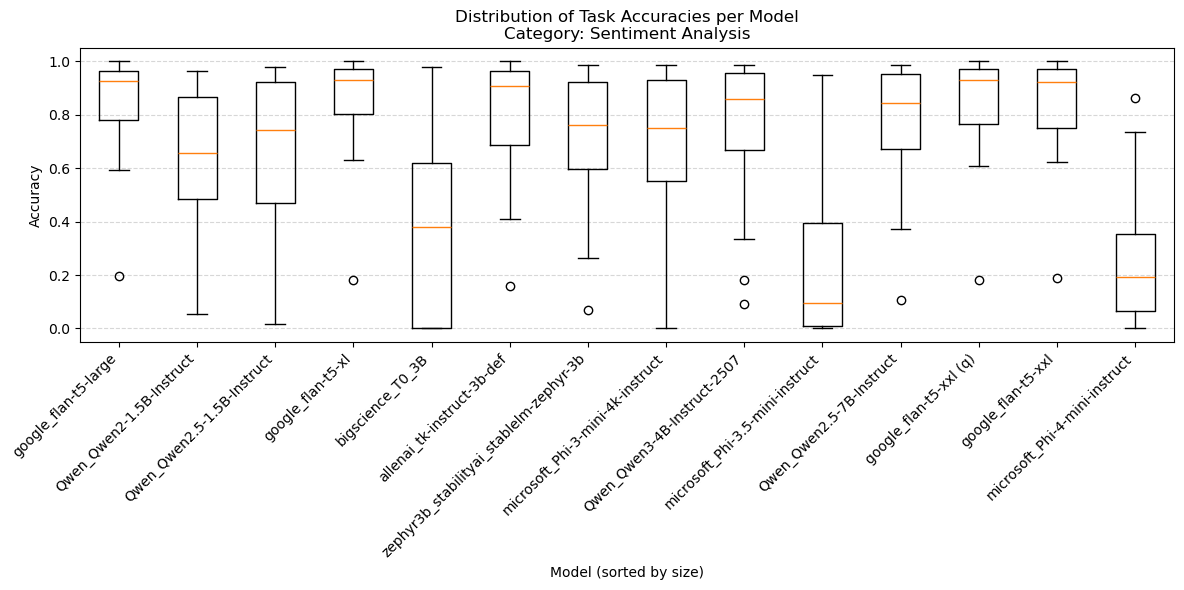

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


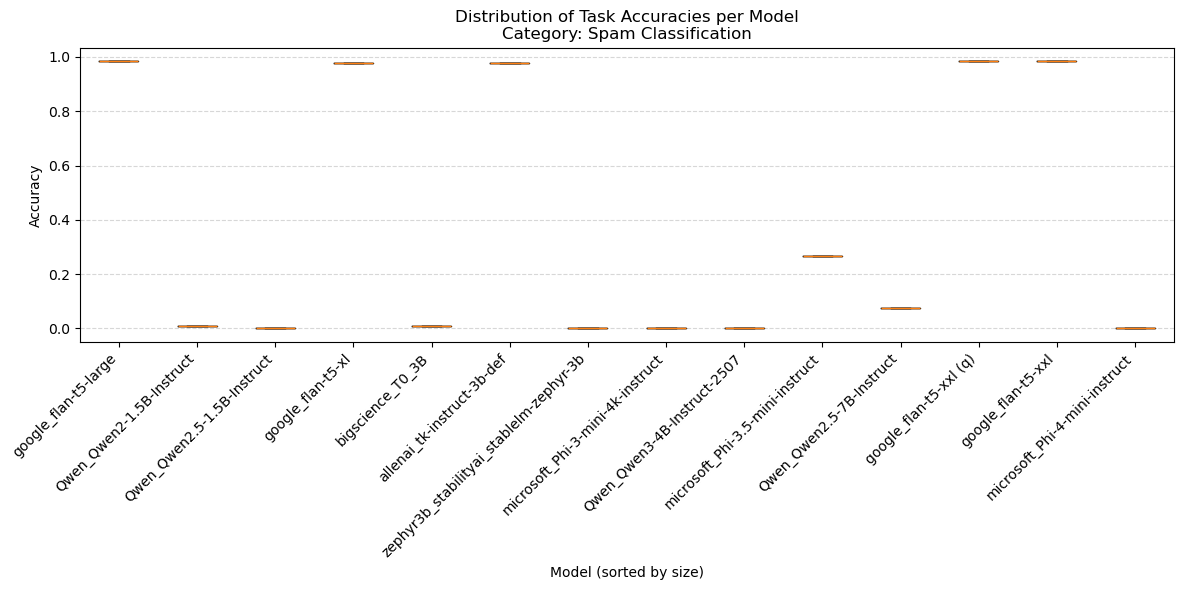

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


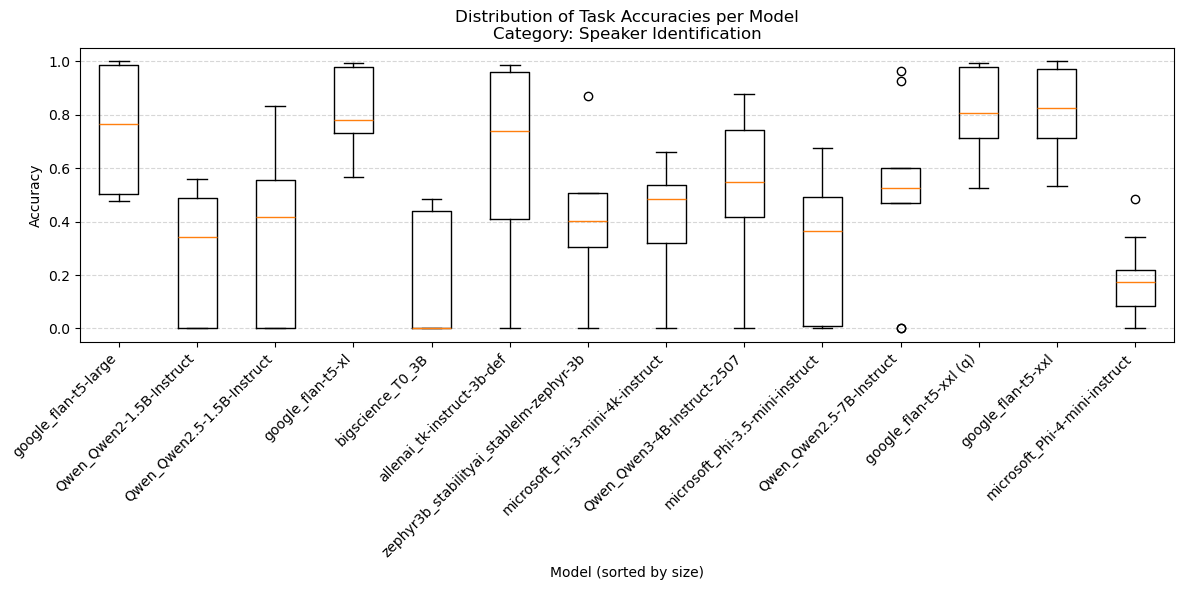

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


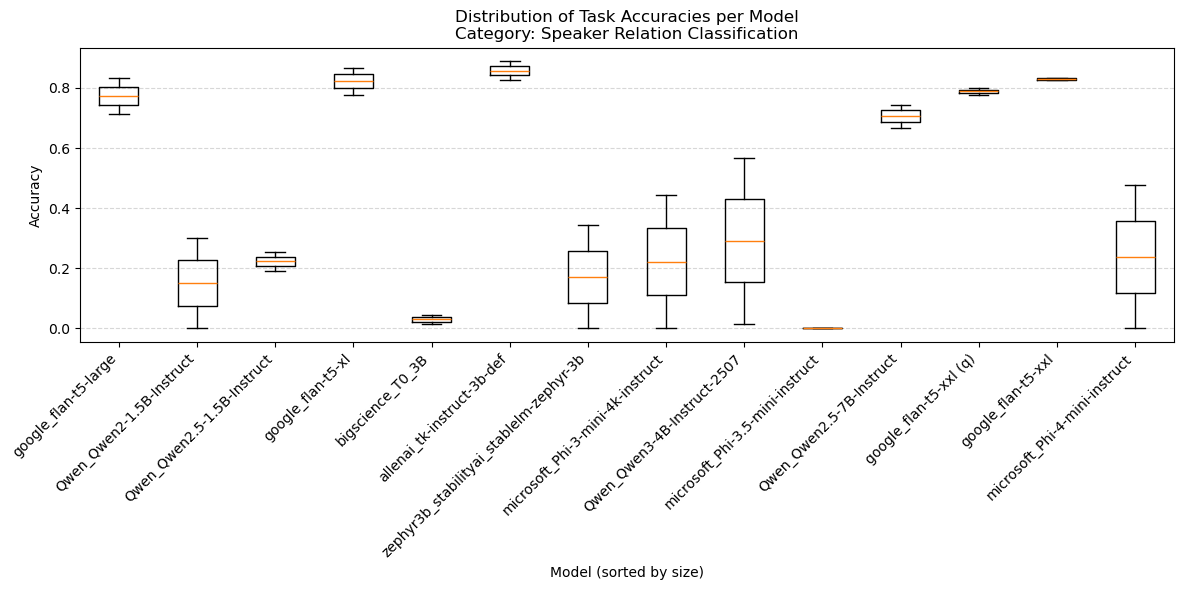

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


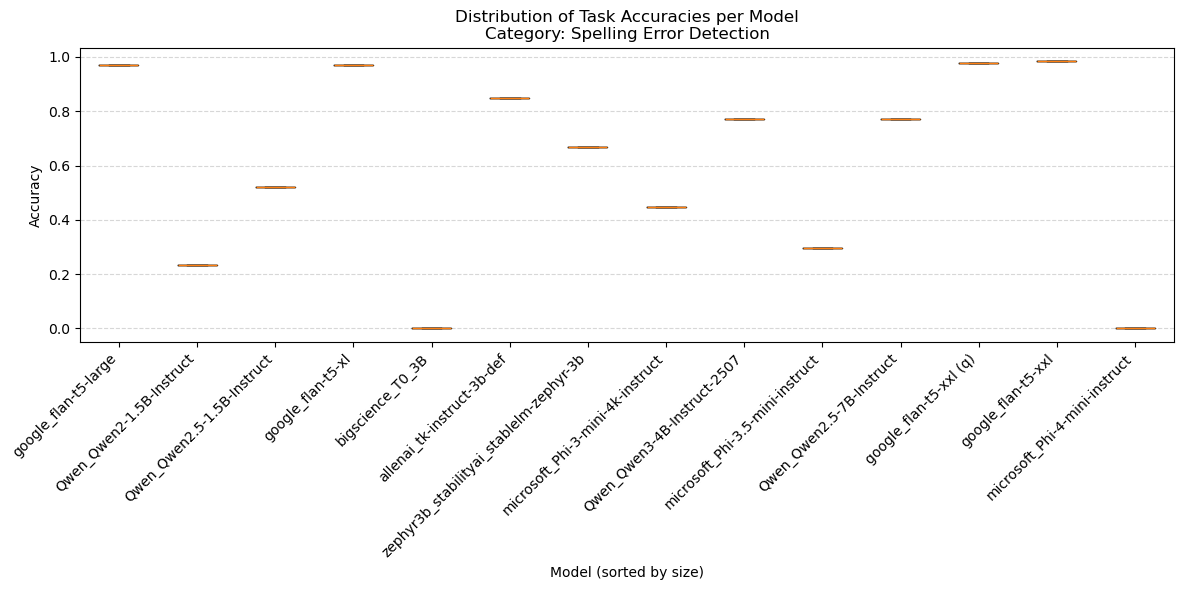

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


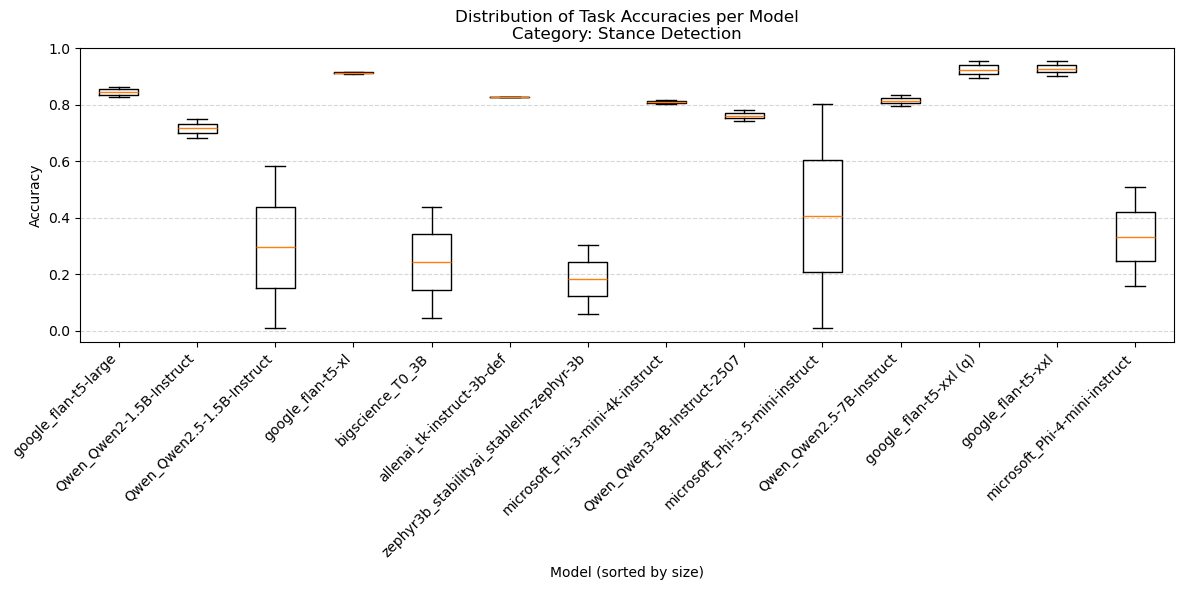

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


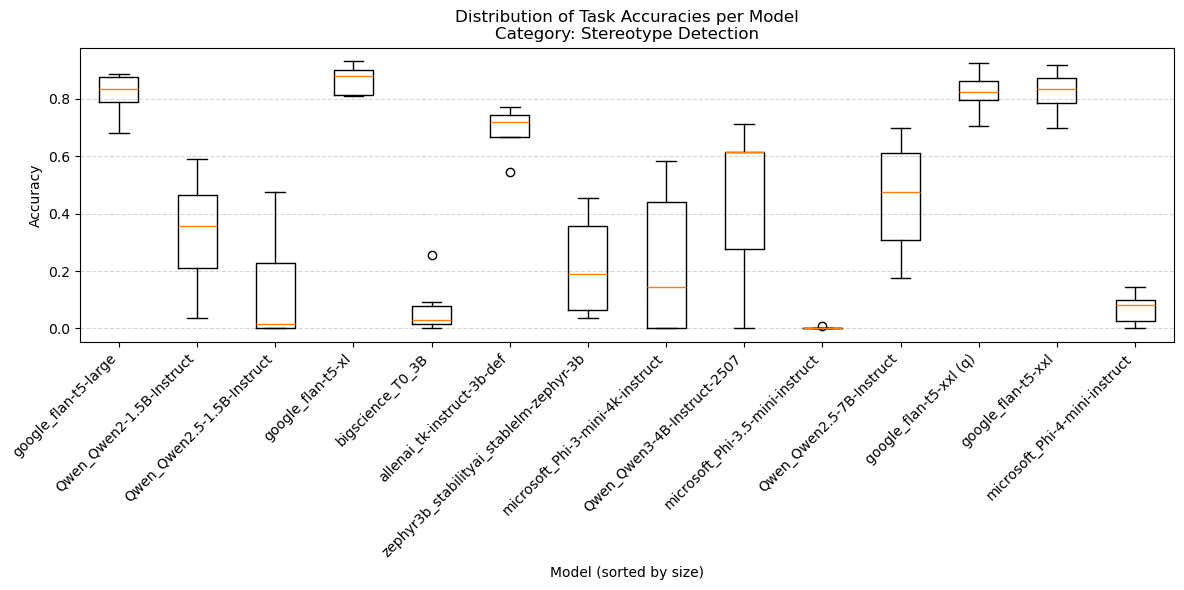

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


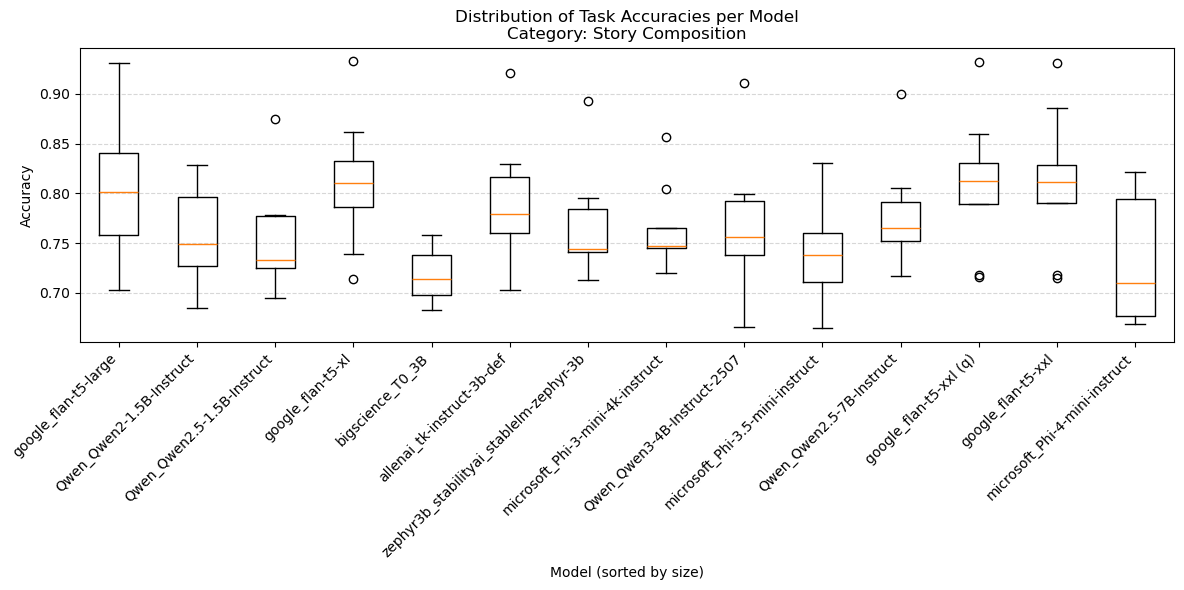

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


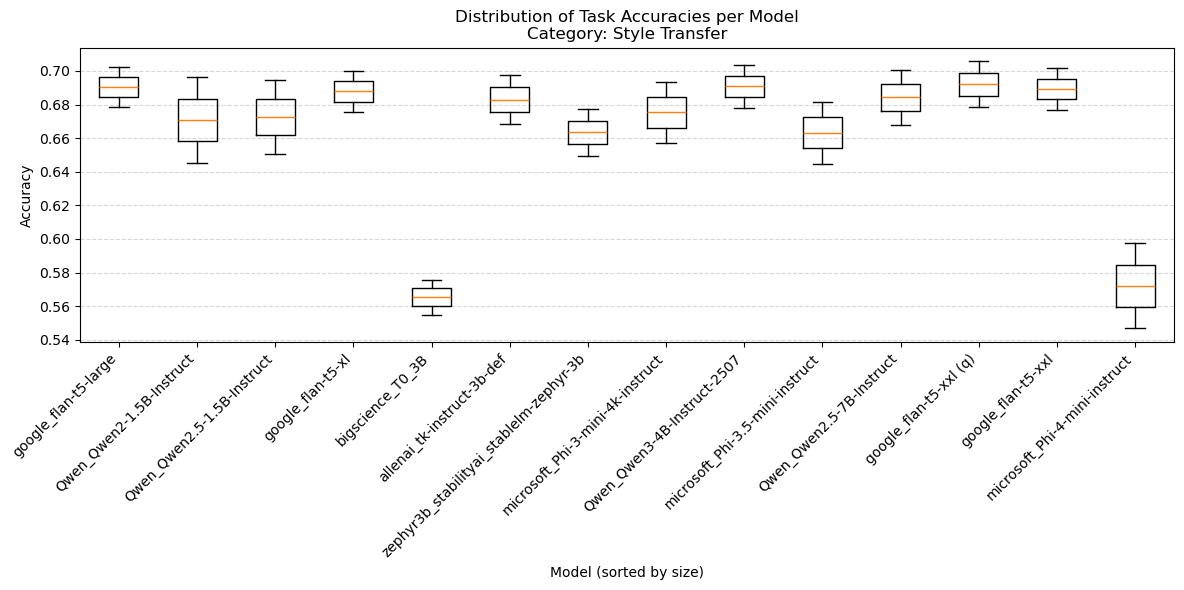

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


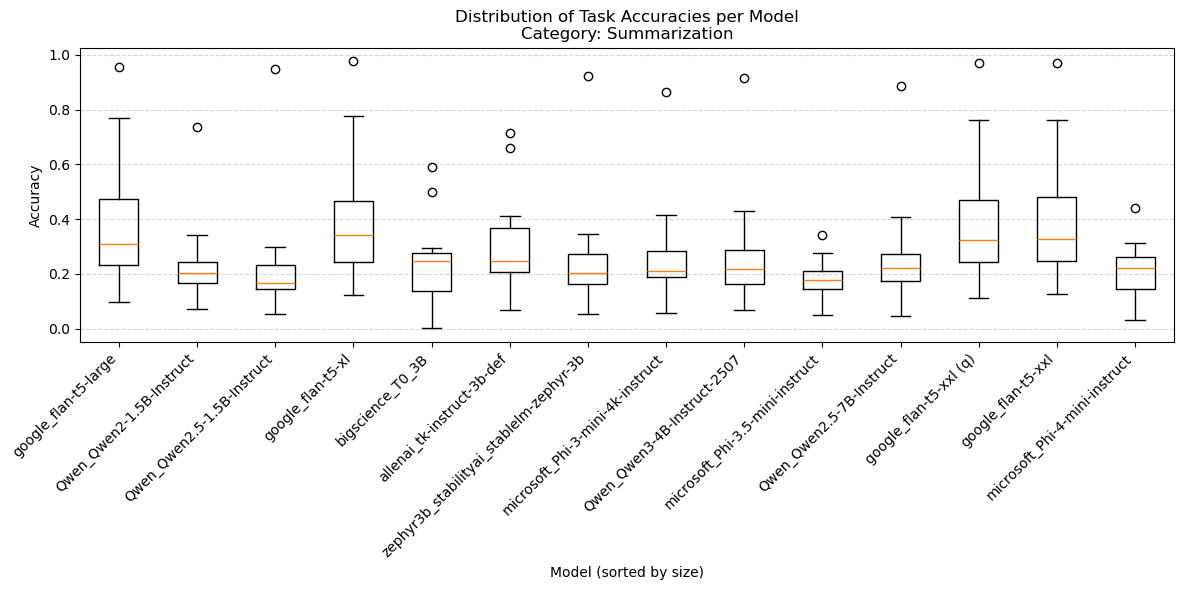

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


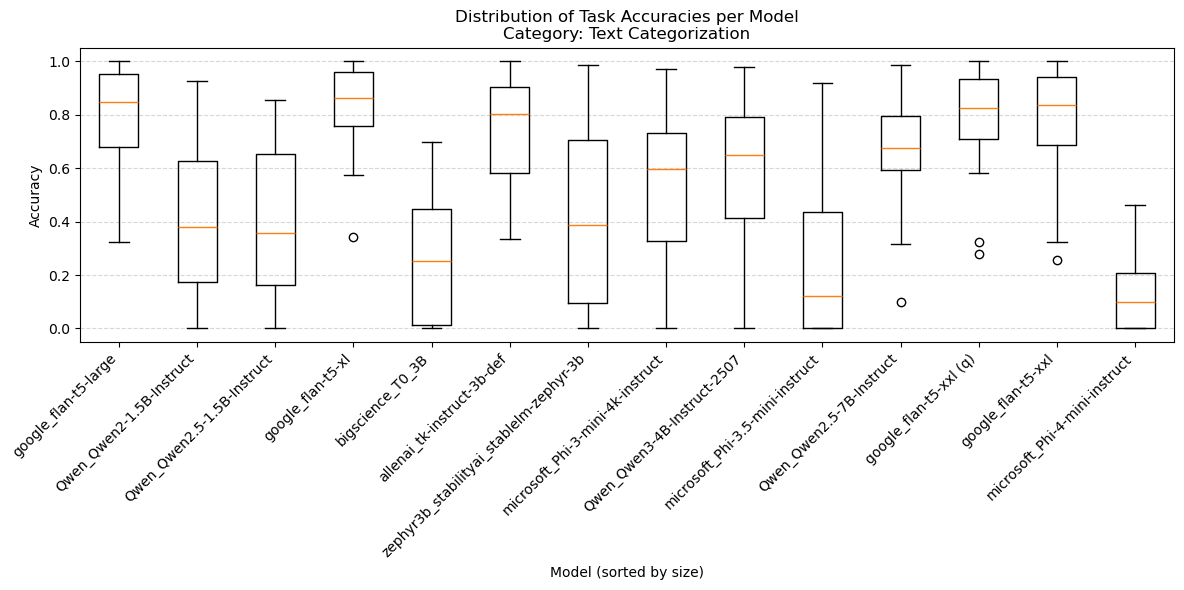

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


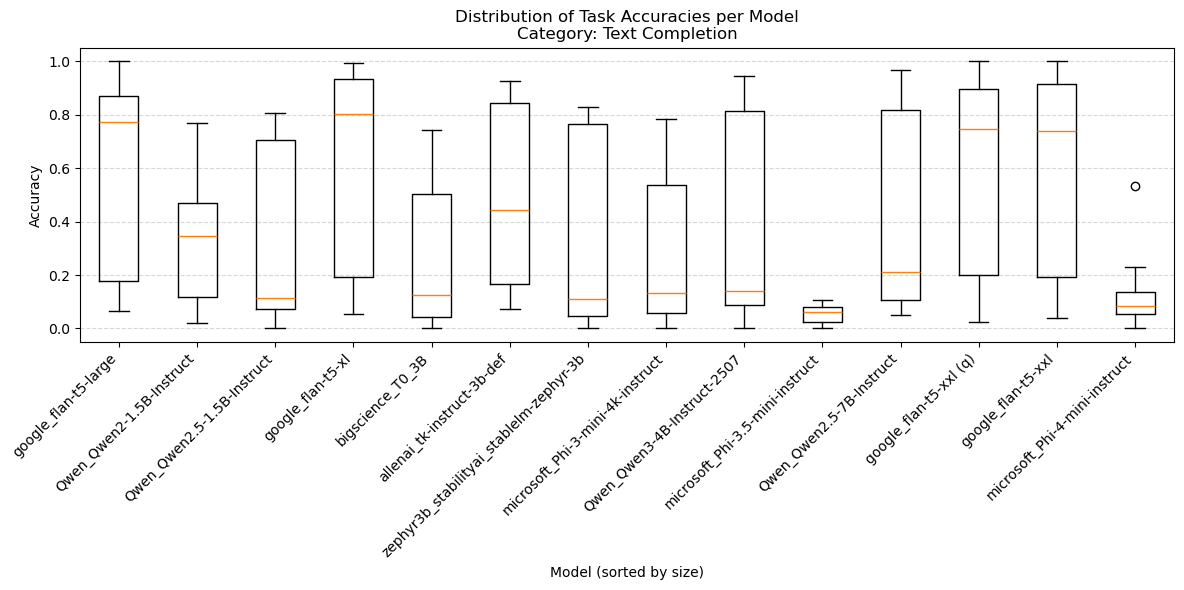

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


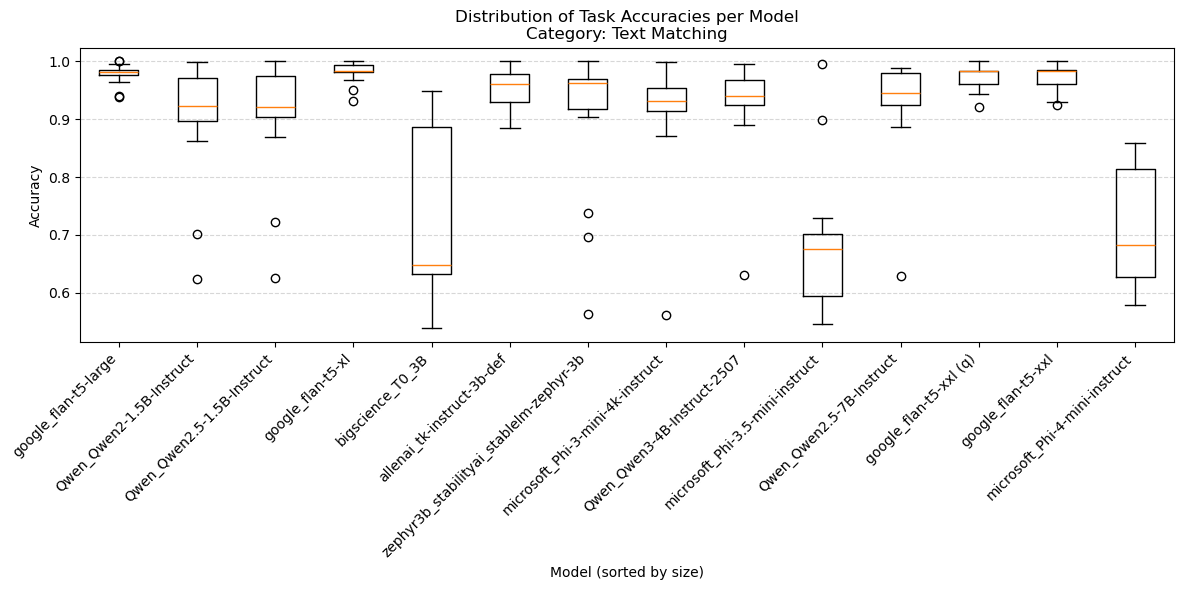

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


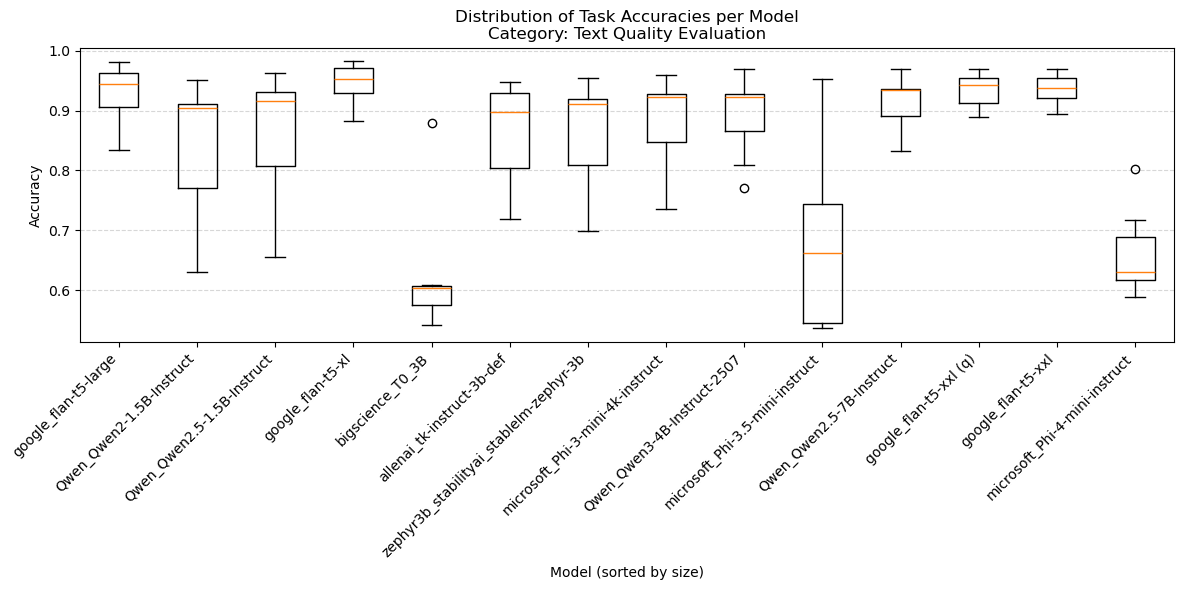

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


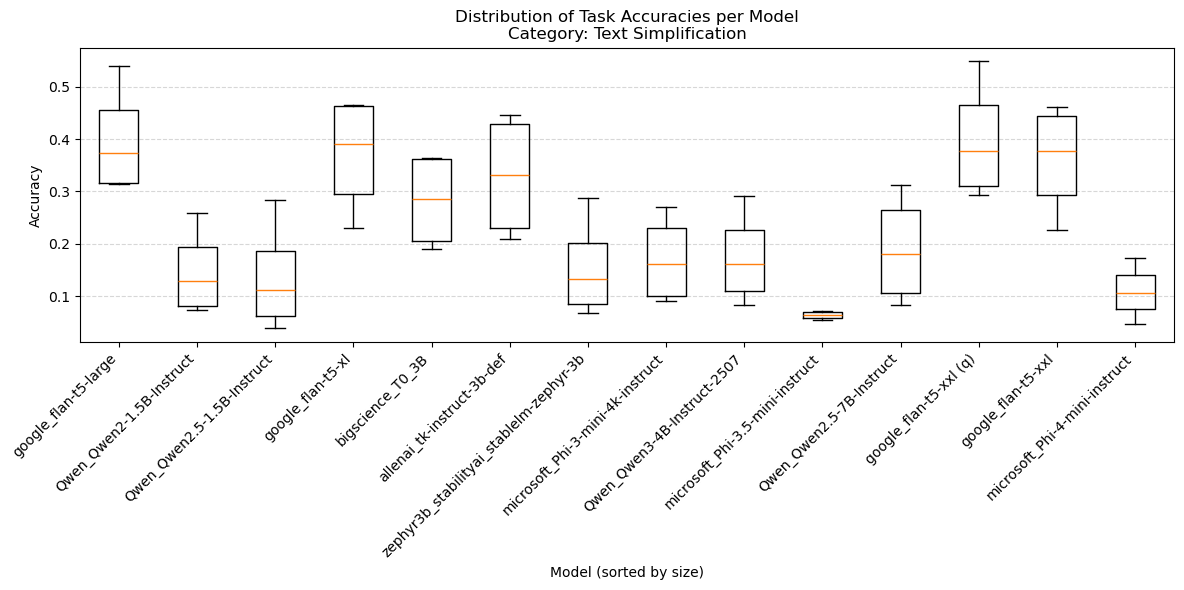

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


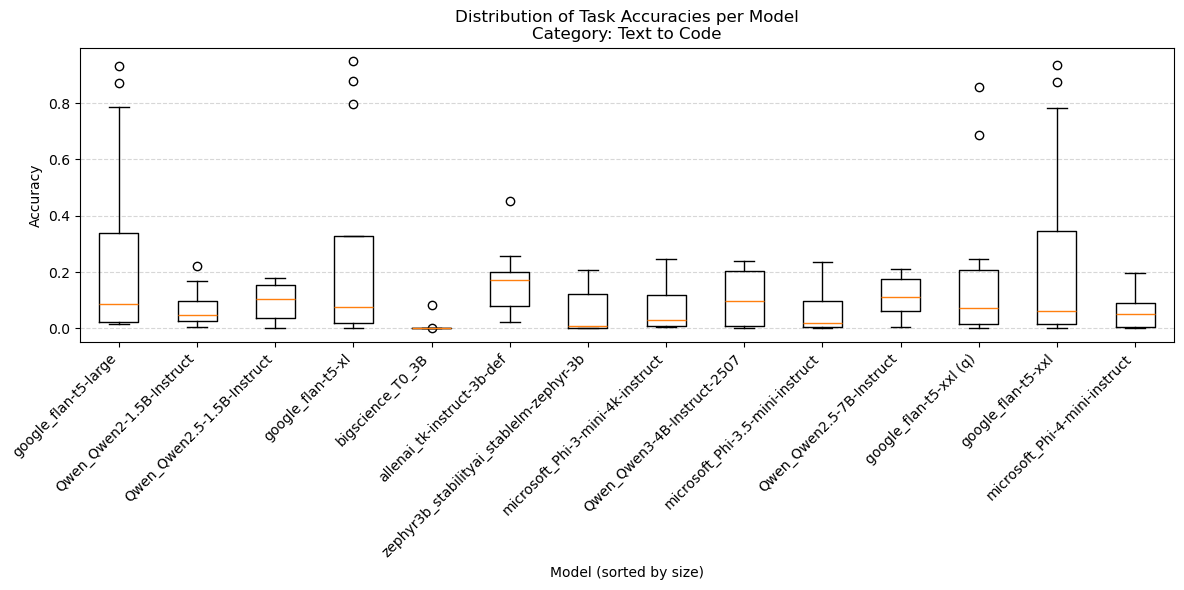

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


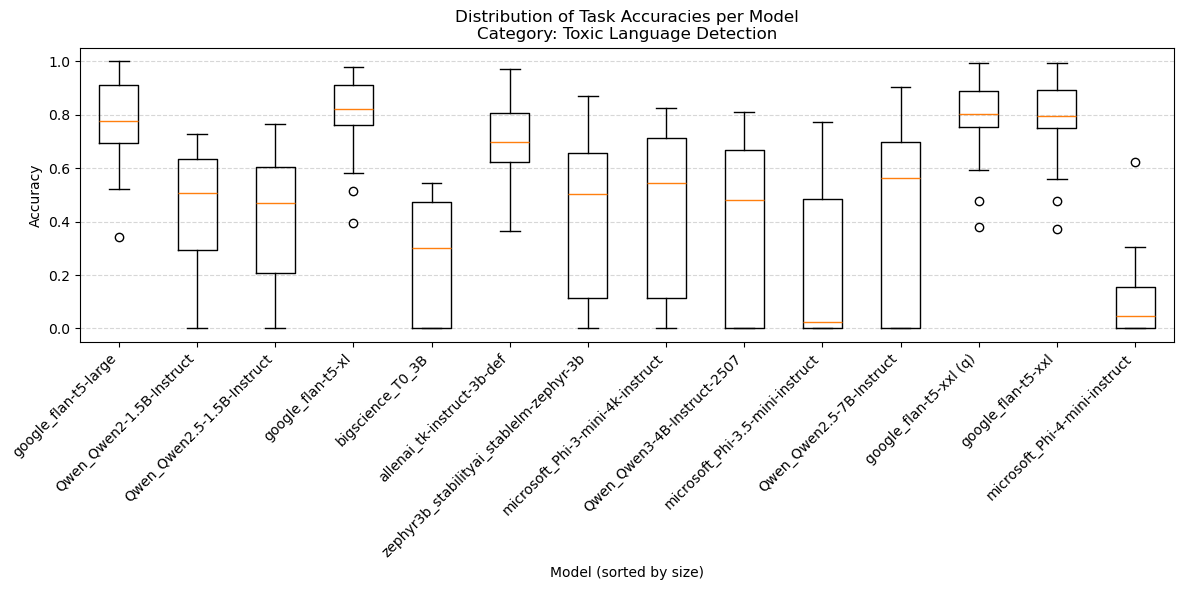

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


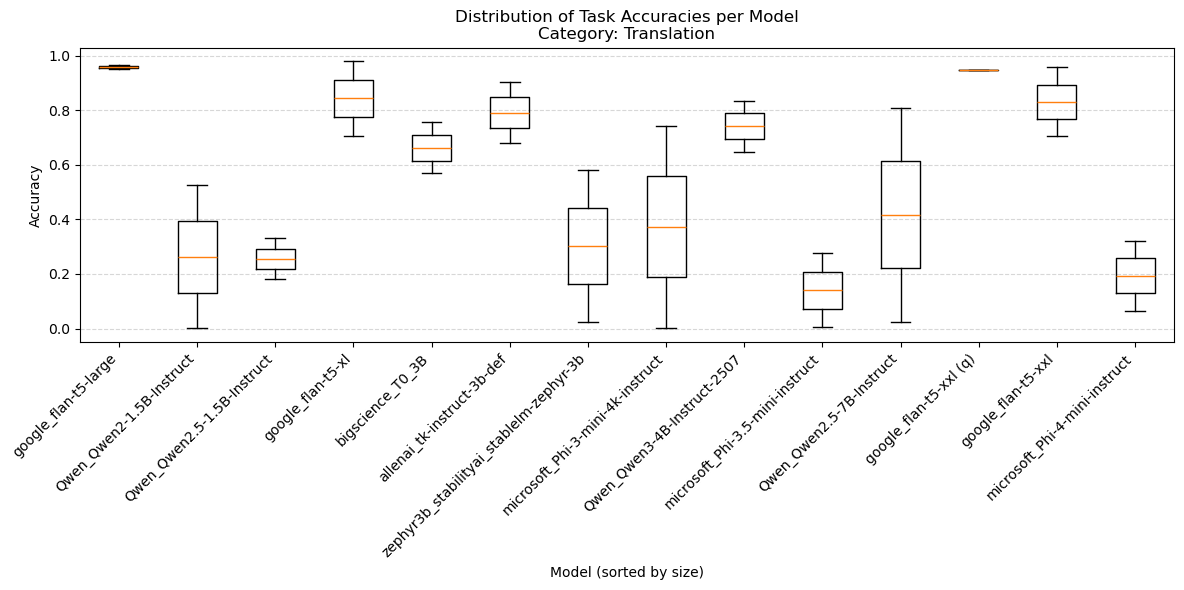

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


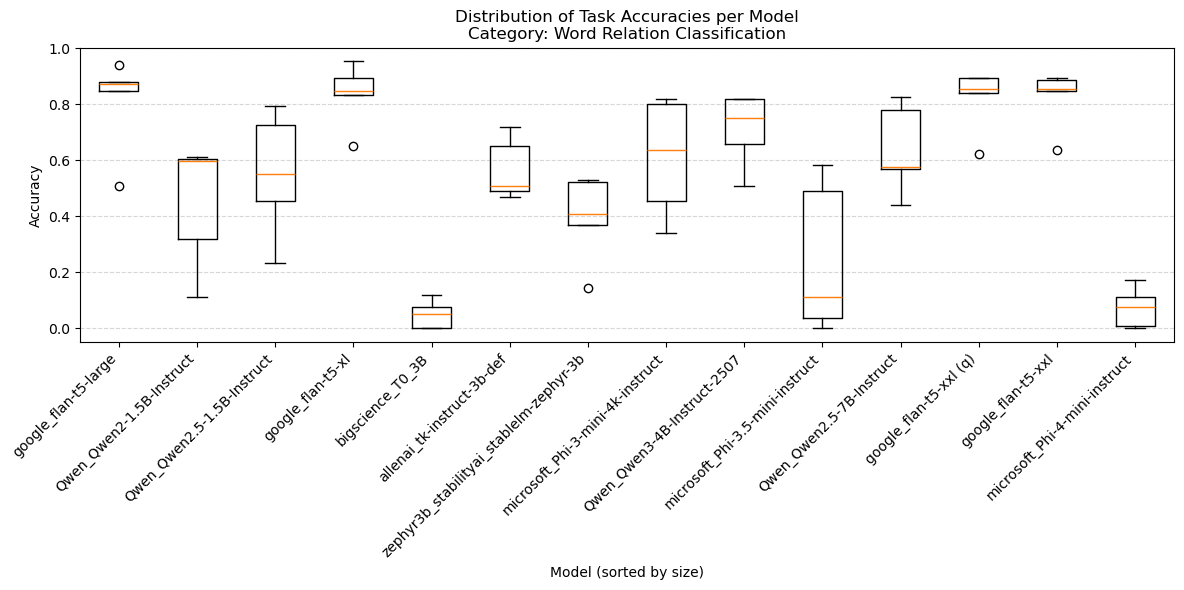

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


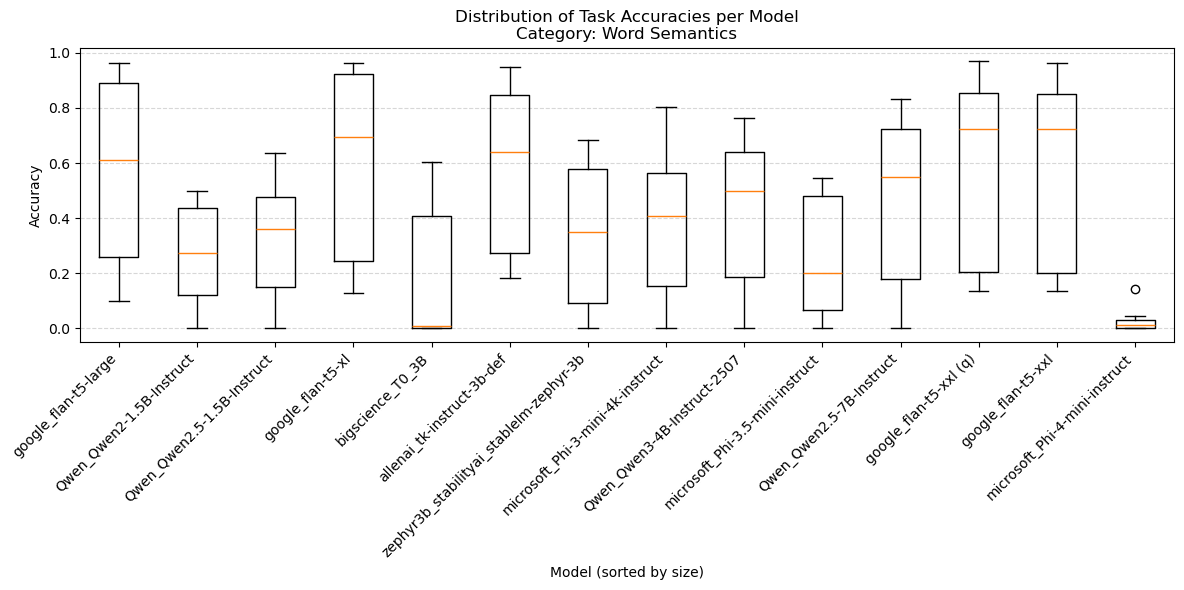

/tmp/ipykernel_6587/1537130718.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


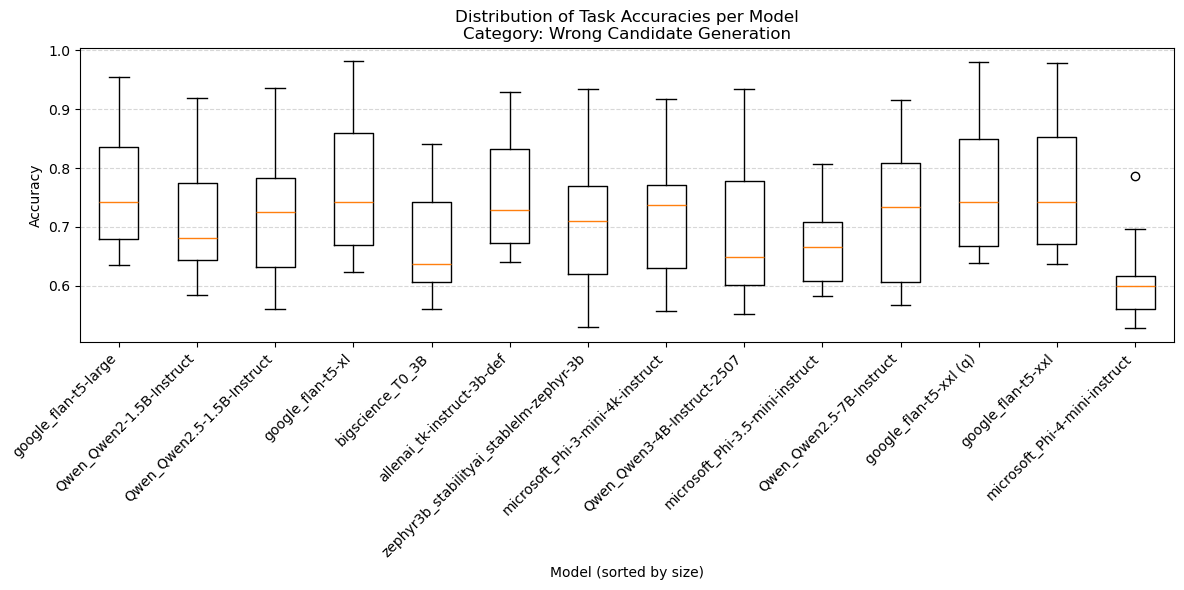

In [ ]:
import matplotlib.pyplot as plt

# Make sure we have model_size_b; if not, map it from MODEL_SIZES
if "model_size_b" not in all_df.columns:
    all_df["model_size_b"] = all_df["model_name"].map(MODEL_SIZES)

# Keep only rows with accuracy, category, and model size
df_acc_cat = all_df.dropna(subset=["avg_acc", "category", "model_size_b"])

all_categories = sorted(df_acc_cat["category"].unique())
print(f"Found {len(all_categories)} categories")

for category_name in all_categories:
    cat_df = df_acc_cat[df_acc_cat["category"] == category_name]

    # Require at least 2 models in this category
    if cat_df["model_name"].nunique() < 2:
        print(f"Skipping category '{category_name}' (fewer than 2 models)")
        continue

    # Get unique (model, size) pairs within this category
    model_sizes = (
        cat_df[["model_name", "model_size_b"]]
        .drop_duplicates()
        .sort_values("model_size_b")
    )

    sorted_models = model_sizes["model_name"].tolist()

    # Build accuracy arrays in size-sorted model order
    data_per_model = [
        cat_df.loc[cat_df["model_name"] == m, "avg_acc"].values
        for m in sorted_models
    ]

    plt.figure(figsize=(12, 6))
    plt.boxplot(
        data_per_model,
        labels=sorted_models,
        showfliers=True,
        vert=True,
    )

    plt.title(f"Distribution of Task Accuracies per Model\nCategory: {category_name}")
    plt.xlabel("Model (sorted by size)")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
